Federico Zanotti (ID: 2007716) - Lorenzo Corrado (ID: 2020623)

# Zeroth Order Methods for Adversarial Machine Learning
### Optimization for Data Science Project

September 16, 2021


## Import and Data preparation


In [ ]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from keras.optimizers import Optimizer
from keras.models import Model
from scipy.special import softmax
from scipy.optimize import minimize
from scipy.special import softmax
from tqdm import tqdme
import random
import gzip
import urllib.request
import time
import warnings
import os
from prettytable import PrettyTable


# Remove warnings in output
warnings.filterwarnings("ignore")

# Set seed
np.random.seed([2021])

: 

In [ ]:
# Download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

# Model/data parameters
num_classes = 10
input_shape = (784,)

# Scale images in [0,1] range
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

# Make sure images have shape (28,28,1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))

# Splitting training set in training and valid
validation_size = 5000

x_val = x_train[:validation_size]
y_val = y_train[:validation_size]
x_train = x_train[validation_size:]
y_train = y_train[validation_size:]

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Define DNN architecture
model = keras.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(tf.keras.layers.Reshape((28,28,1), input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(200, activation="relu"))
model.add(tf.keras.layers.Dense(num_classes, name="last_dense"))
model.add(tf.keras.layers.Activation("softmax"))

In [ ]:
# # Take the output of the last layer before the softmax operation
dnn = Model(inputs=model.input, outputs=model.get_layer("last_dense").output)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Loads the weights
path = "/content/mnist"
if os.path.isfile(path):
  model.load_weights(path) 

  # Evaluate the model on the test set
  score = model.evaluate(x_test, y_test, verbose=0)
  print("Test loss:", score[0])
  print("Test accuracy: {} %".format(score[1]*100))
else:
  print(f"file {path} does not exist")



Test loss: 0.2394988238811493
Test accuracy: 94.44000124931335 %


## Utility Function

In [ ]:
# Definition of the objective function to be minimized #(FOR ALL THE SAMPLES)
def F(x, y_true):
  """
  Loss function for all the examples

  Input:
  - x: images
  - y_true: true labels of the images

  """
  f = dnn.predict(x)    
  f_yi = np.max(f*y_true, axis=1)
  f_j = np.max(f*np.where(y_true == 1, -1e10, 1), axis=1)
  
  return np.mean(np.where(f_yi - f_j > 0, f_yi - f_j, 0))

def F_Par(x, y_true):
  """
  Loss function for only one example

  Input:
  - x: image
  - y: true label of the image

  """
  f = dnn.predict(x)
  f_yi = np.max(f*y_true, axis=1)
  f_j = np.max(f*np.where(y_true == 1, -1e10, 1), axis=1)

  return np.where(f_yi-f_j > 0, f_yi-f_j, 0)

In [ ]:
# Extract n images from the same class
def extract_images(n, c):
  """
  Extract some images of the same class

  Input:
  - n: number of images to extract
  - c: label

  """
  x_extr = np.copy(x_test[y_test.argmax(axis=1)==c][:n])
  y_extr = np.copy(y_test[y_test.argmax(axis=1)==c][:n])
  
  return x_extr, y_extr

In [ ]:
# Set the number of examples in the same class
def get_data(n, c):
  """
  return x, x_ori, y_true_in

  """
  img_in, y_true_in = extract_images(n,c)
  x_ori = np.copy(img_in)
  x = np.copy(x_ori)
  return x, x_ori, y_true_in 

In [ ]:
def stop_attack(x, y_true):
  success = dnn.predict(x).argmax(axis=1)
  # print("Label predicted:", success)
  return sum(success==y_true.argmax(axis=1))==0


In [ ]:
def RandGradEst(x, y_true, v):
  """
  Two-point (gaussian) random gradient estimator

  Input:
  - x: image
  - y_true: true label of the image
  - v: smoothing parameter 
  """
  u = np.random.standard_normal((1,d))
  F_plus = F(x + v*u, y_true)
  F_ = F(x, y_true)
  
  return (d/v)*(F_plus - F_)*u

In [ ]:
def Avg_RandGradEst(x, y_true, q, v):
  """
  Averaged (gaussian) random gradient estimator

  Input:
  - x: image
  - y_true: true label of the image
  - q: number of random directions
  - v: smoothing parameter
  """
  g = 0
  u = np.random.standard_normal((q,d))
  F_ = F(x, y_true)
  for j in range(q):
    F_plus = F(x + v*u[j], y_true)
    g = g + (F_plus - F_)*u[j]

  return (d/(v*q))*g

In [ ]:
def CoordGradEst(x, y_true, mu):
  """
  Coordinate-wise gradient estimator
  
  Input:
  - x: images
  - y_true: true labels of the images
  - mu: smoothing parameter

  """
  q = 0
  for j in tqdm(range(d)):
    F_plus = F(x + mu*e(j,d), y_true)
    F_minus = F(x - mu*e(j,d), y_true)
    diff = F_plus - F_minus
    q = q + (diff)*e(j,d)
   
  return q/(2*mu)

In [ ]:
def attack_success_rate(x, y):
  predicted=softmax(dnn.predict(x)).argmax(axis=1)
  # print(predicted)
  true_values=y.argmax(axis=1)
  adversarial=len(predicted)-sum(predicted==true_values)
  wrong_label=(adversarial/len(predicted))*100
  return round(wrong_label,1)


In [ ]:
def plot_all(loss_ZSCG, loss_FZFW, loss_FZCGS, epochs, n, savefig=''):
  plt.figure(figsize=(10,8))
  plt.plot(loss_ZSCG, label=f"ZSCG with {n} examples")
  plt.plot(loss_FZFW, label=f"FZFW with {n} examples")
  plt.plot(loss_FZCGS, label=f"FZCGS with {n} examples")
  plt.grid("on")
  plt.legend()
  plt.xticks(np.arange(0,epochs+10,10))
  plt.xlabel("# iterations")
  plt.ylabel("loss")
  if savefig != '':
    plt.savefig(savefig)
  plt.show()




In [ ]:
def nice_table(x_mod, y_true, param1, param2):
  param1_list = param1[1]
  param2_list = param2[1]
  j=0
  i=0
  t= PrettyTable([param1[0], param2[0], "ASR (%)"])
  for el in x_mod:
    asr=attack_success_rate(el, y_true)
    if i==len(param2_list):
      i=0
      p2 = param2_list[i]
      j +=1
      p1=param1_list[j]
    else:
      p2 = param2_list[i]
      p1=param1_list[j]
    i +=1
    
    t.add_row([f" {p1}", f" {p2}", asr])
  return t

## Algorithm 1. Zeroth-Order Stochastic Conditional Gradient Method (ZSCG)

K. Balasubramanian et al., 2018.

In [ ]:
def Avg_RandGradEst_Par(x, y_true, q, v, d):
  """
  Averaged (gaussian) random gradient estimator in parallel

  Input:
  - x: image
  - y_true: true label of the image
  - q: number of random directions
  - v: smoothing parameter
  """
  g = 0
  u = np.random.standard_normal((q,d))
  x_par_plus = np.array([x + v*u[j] for j in range(q)]).reshape((q,d))
  diff = F_Par(x_par_plus, y_true) - F(x, y_true)

  for j in range(q):
    g = g + (diff[j]/v) * u[j] 
  
  return (d/(q*v))*g

In [ ]:
def ZSCG(N, d, s, m_k, x, y_true_in,v=-1,alpha=-1, B=1,verbose=True, clip=False):
  if v==-1:
    v = np.sqrt(2/(N*(d+3)**3))
  if alpha==-1:
    alpha = 1/np.sqrt(N)

  x_ori=np.copy(x)
  loss_ZSCG = []
  perturbations = []
  loss_ZSCG.append(F(x, y_true_in))
  if verbose:
    print("Epoch:", 0, "Loss:", F(x_ori, y_true_in), "Distortion:", np.max(np.abs(x-x_ori)))
  for k in range(N):
      
    # Get the gradient estimate
    v_k = 0
    for i in tqdm(range(x.shape[0]), disable= not verbose):
      # v_k = v_k + RandGradEst(x[i:i+1], y_true_in[i:i+1], v)
      # v_k = v_k + Avg_RandGradEst(x[i:i+1], y_true_in[i:i+1], 30, v)
      v_k = v_k + Avg_RandGradEst_Par(x[i:i+1], y_true_in[i:i+1], m_k, v, d)    
    v_k = (1/n)*v_k
    
    x_k = -s * np.sign(v_k) + x_ori # Solve the LMO
    x = (1 - alpha)*x+ alpha*x_k
    if clip:
      x= x_ori + np.clip((x-x_ori), 0, 1)
    perturbations.append(x)
    loss_ZSCG.append(F(x, y_true_in))
    if verbose:
      print("-"*100)
      print("Epoch:", k+1, "Loss:", loss_ZSCG[k], "Distortion:", np.round(np.max(np.abs(x-x_ori)),5), "Elapsed Time:")
    if stop_attack(x, y_true_in):
      print("Attack successful! stopping computation...")
      return loss_ZSCG, x
  # x = np.clip(x, 0, 1)

  ZSCG_x_perturbated = x

  print("ZSCG Final loss = ", loss_ZSCG[-1])
  return loss_ZSCG, ZSCG_x_perturbated, perturbations

## Algorithm 2. Faster Zeroth-Order Frank-Wolfe Method (FZFW)
Gao et al., 2020.

In [ ]:
def e(i, d):
  """
  Orthogonal basis vector

  Input:
  - i: index
  - d: dimensions
  
  """
  ei = np.zeros(d)
  ei[i] = 1
  return ei

In [ ]:
def CoordGradEst_Par(x, y_true, mu,d):
  """
  Coordinate-wise gradient estimator in parallel

  Input:
  - x: image
  - y_true: true label of the image
  - mu: smoothing parameter
  
  """
  x_par_plus = np.array([x + mu*e(j,d) for j in range(d)]).reshape(d,d)
  x_par_minus = np.array([x - mu*e(j,d) for j in range(d)]).reshape(d,d)
  diff = F_Par(x_par_plus, y_true) - F_Par(x_par_minus, y_true)
  
  q = 0
  for j in range(d):
    q = q + (diff[j])*(e(j,d)) 
    
  return (1/(2*mu))*q

In [ ]:
def FZFW(K,d,n,s,gamma, mu,x,y_true_in, verbose=True, clip=False): 
  s_1=n
  q = s_2 = int(np.sqrt(n))
  if gamma==-1:
    gamma = 1/np.sqrt(K)
  if mu==-1:
    mu = 1/np.sqrt(d*K)
  x_ori=np.copy(x)


  loss_FZFW = []
  perturbations=[]
  loss_FZFW.append(F(x_ori, y_true_in))
  if verbose:
    print("Epoch:", 0, "Loss:", F(x_ori, y_true_in), "Distortion:", np.max(np.abs(x-x_ori)))
    print("-"*100)


  for k in range(K):
    if (k % q == 0):
      

      ########################################################
      ####### Get the gradient estimate with S1>S2 samples #######
      v_k = 0
      for i in tqdm(range(s_1), disable= not verbose):
        v_k = v_k + CoordGradEst_Par(x[i:i+1], y_true_in[i:i+1], mu,d)
      v_k=v_k/s_1
      v_k_1 = v_k
      ########################################################

    else:

      ########################################################
      ##### Get the gradient estimate with S2<S1 samples #####

      v_k = 0
      s2_idx = np.random.randint(0, n, s_2) 

      for idx in tqdm(s2_idx,  disable= not verbose):
        v_k = v_k + CoordGradEst_Par(x[idx:idx+1], y_true_in[idx:idx+1], mu,d) - CoordGradEst_Par(x_k_1[idx:idx+1], y_true_in[idx:idx+1], mu,d) + v_k_1
      v_k = (1/s_2) * v_k
      v_k_1 = v_k

      ########################################################

    #########################################
    ############# Update x ##################

    x_k_1 = np.copy(x)
    u_k = -s * np.sign(v_k) + x_ori # Solve the LMO
    d_k = u_k - x
    x = x + gamma*d_k

    #########################################    

    if clip:
      x= x_ori + np.clip((x-x_ori), 0, 1)
    perturbations.append(x)

    loss_FZFW.append(F(x, y_true_in))
    if verbose:
      print("Epoch:", k+1, "Loss:", loss_FZFW[k+1], "Distortion:", np.round(np.max(np.abs(x-x_ori)),5))
      print("-"*100)
    if stop_attack(x, y_true_in):
      print("Attack successful! stopping computation...")
      return loss_FZFW, x
    

 
  FZFW_x_perturbated = x

  print("FZFW Final loss = ", loss_FZFW[-1])

  return loss_FZFW, FZFW_x_perturbated, perturbations


## Algorithm 3. Faster Zeroth-Order Conditional Gradient Sliding Method (FZCGS)

Gao et al., 2020.

In [ ]:
def CondG(g, u, gamma, eta, x_ori, s, d):
  t=1
  u_t=u
  
  while (True):
    grad = g + (1/gamma)*(u_t-u)
    v = -s * np.sign(g) + x_ori
    V = np.dot(grad, (u_t-v).T)
    if (np.max(V) <= eta):
      return u_t
    if t==100:
      return u_t

    else:
      
      d = v-u_t
      alpha = np.dot((1/gamma) * (u-u_t)-g, d.T) / ((1/gamma)*np.dot(d, d.T))
      alpha = np.min(alpha) 
      if (alpha > 1):
        alpha = 1     
      u_t = (1-alpha)*u_t + alpha*v
      t = t+1
  


In [ ]:
def FZCGS(K,d,n,s,gamma, mu, eta, x,y_true_in, verbose=True, clip=False):
  s_1 = n
  q = s_2 = int(np.sqrt(n))
  if gamma==-1:
    gamma = 1/np.sqrt(K)
  if mu==-1:
    mu = 1/np.sqrt(d*K)
  if eta==-1:
    eta = 1/K
  x_ori=np.copy(x)


  loss_FZCGS = []
  perturbations=[]
  loss_FZCGS.append(F(x_ori, y_true_in))
  if verbose:
    print("Epoch:", 0, "Loss:", F(x_ori, y_true_in), "Distortion:", np.max(np.abs(x-x_ori)))
    print("-"*100)

  for k in range(K):
    
    if (k % q == 0):
      ########################################################
      ##### Get the gradient estimate with S1>S2 samples #####

      v_k = 0
      for i in tqdm(range(s_1), disable=not verbose):
        v_k = v_k + CoordGradEst_Par(x[i:i+1], y_true_in[i:i+1], mu,d)
      v_k=v_k/s_1
      v_k_1 = v_k

      ########################################################
    else:
      ########################################################
      ##### Get the gradient estimate with S2<S1 samples #####

      v_k = 0
      s2_idx = np.random.randint(0, n, s_2) 
    
      for idx in tqdm(s2_idx,  disable= not verbose):
        # idx = np.random.randint(0,n)
        v_k = v_k + CoordGradEst_Par(x[idx:idx+1], y_true_in[idx:idx+1], mu, d) - CoordGradEst_Par(x_k_1[idx:idx+1], y_true_in[idx:idx+1], mu,d) + v_k_1
      v_k = (1/s_2) * v_k
      v_k_1 = v_k
      
      ########################################################

    #########################################
    ############# Update x ##################

    x_k_1 = np.copy(x)
    x = CondG(v_k, x, gamma, eta, x_ori, s, d) # Cong procedure

    ##########################################

    if clip:
      x= x_ori + np.clip((x-x_ori), 0, 1)
    perturbations.append(x)
    loss_FZCGS.append(F(x, y_true_in))
    if verbose:
      print("-"*100)
      print("Epoch:", k+1, "Loss:", loss_FZCGS[k], "Distortion:", np.round(np.max(np.abs(x-x_ori)),5))
    if stop_attack(x, y_true_in):
      print("Attack successful! stopping computation...")
      return loss_FZCGS, x
    


  FZCGS_x_perturbated = x

  print("FZCGS Final loss = ", loss_FZCGS[-1])

  return loss_FZCGS, FZCGS_x_perturbated, perturbations

## Experiments



### More Examples

#### Example same class

In [ ]:
n=100
x, _, y_true_in = get_data(n, 4)
epochs=100


In [ ]:
F(x, y_true_in)

19.96631116487086

In [ ]:
# loss_Z, x_Z, p1=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,verbose=True)
loss_FZ, x_FZ,p2=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=True)
loss_FZC, x_FZC,p3=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=True)


Epoch: 0 Loss: 19.96631116487086 Distortion: 0.0
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch: 1 Loss: 18.414860124886037 Distortion: 0.01
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch: 2 Loss: 16.982202967703344 Distortion: 0.019
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 3 Loss: 15.559964186698199 Distortion: 0.0271
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch: 4 Loss: 14.209140155166388 Distortion: 0.03439
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch: 5 Loss: 12.921340660005807 Distortion: 0.04095
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch: 6 Loss: 11.657543739378452 Distortion: 0.04686
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch: 7 Loss: 10.57773790359497 Distortion: 0.05217
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 8 Loss: 10.193774896860123 Distortion: 0.05695
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch: 9 Loss: 9.869763301610947 Distortion: 0.06126
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 10 Loss: 9.573044766187667 Distortion: 0.06513
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch: 11 Loss: 8.51496253490448 Distortion: 0.06862
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 12 Loss: 7.620898698568344 Distortion: 0.07176
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 13 Loss: 6.8902457284927365 Distortion: 0.07458
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]


Epoch: 14 Loss: 6.246859810352325 Distortion: 0.07712
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch: 15 Loss: 5.708689825534821 Distortion: 0.07941
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch: 16 Loss: 5.242538485527039 Distortion: 0.08147
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch: 17 Loss: 4.8505139374732975 Distortion: 0.08332
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch: 18 Loss: 4.514372432231903 Distortion: 0.08499
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch: 19 Loss: 4.212749757766724 Distortion: 0.08649
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch: 20 Loss: 3.947083990573883 Distortion: 0.08784
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch: 21 Loss: 3.6365516424179076 Distortion: 0.08906
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch: 22 Loss: 3.400740530490875 Distortion: 0.09015
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 23 Loss: 3.1976635909080504 Distortion: 0.09114
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 24 Loss: 3.0383629608154297 Distortion: 0.09202
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 25 Loss: 2.8997755956649782 Distortion: 0.09282
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 26 Loss: 2.782739129066467 Distortion: 0.09354
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 27 Loss: 2.670531530380249 Distortion: 0.09419
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 28 Loss: 2.572794485092163 Distortion: 0.09477
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Epoch: 29 Loss: 2.498902127742767 Distortion: 0.09529
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch: 30 Loss: 2.4300625777244567 Distortion: 0.09576
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch: 31 Loss: 2.2935344529151918 Distortion: 0.09618
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 32 Loss: 2.1825068473815916 Distortion: 0.09657
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 33 Loss: 2.096957221031189 Distortion: 0.09691
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch: 34 Loss: 2.0228498935699464 Distortion: 0.09722
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 35 Loss: 1.9625332975387573 Distortion: 0.0975
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch: 36 Loss: 1.9128311157226563 Distortion: 0.09775
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 37 Loss: 1.874806306362152 Distortion: 0.09797
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 38 Loss: 1.8427797079086303 Distortion: 0.09818
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 39 Loss: 1.8185655641555787 Distortion: 0.09836
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 40 Loss: 1.793321499824524 Distortion: 0.09852
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch: 41 Loss: 1.7272634863853455 Distortion: 0.09867
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 42 Loss: 1.672199993133545 Distortion: 0.0988
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 43 Loss: 1.6254041171073914 Distortion: 0.09892
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 44 Loss: 1.5845870399475097 Distortion: 0.09903
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 45 Loss: 1.5501531529426575 Distortion: 0.09913
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 46 Loss: 1.5260046744346618 Distortion: 0.09921
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 47 Loss: 1.504231939315796 Distortion: 0.09929
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch: 48 Loss: 1.4837447881698609 Distortion: 0.09936
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 49 Loss: 1.4676188111305237 Distortion: 0.09943
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 50 Loss: 1.4531999349594116 Distortion: 0.09948
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch: 51 Loss: 1.4172224116325378 Distortion: 0.09954
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 52 Loss: 1.4749892091751098 Distortion: 0.09958
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 53 Loss: 1.5500978231430054 Distortion: 0.09962
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 54 Loss: 1.632605493068695 Distortion: 0.09966
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 55 Loss: 1.7230146026611328 Distortion: 0.0997
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 56 Loss: 1.8153027844429017 Distortion: 0.09973
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Epoch: 57 Loss: 1.836155743598938 Distortion: 0.09975
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Epoch: 58 Loss: 1.841671769618988 Distortion: 0.09978
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Epoch: 59 Loss: 1.8388507461547852 Distortion: 0.0998
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch: 60 Loss: 1.8302872014045715 Distortion: 0.09982
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch: 61 Loss: 1.7485086297988892 Distortion: 0.09984
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch: 62 Loss: 1.6835927367210388 Distortion: 0.09985
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 63 Loss: 1.6370704221725463 Distortion: 0.09987
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Epoch: 64 Loss: 1.5920508909225464 Distortion: 0.09988
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 65 Loss: 1.551303918361664 Distortion: 0.09989
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 66 Loss: 1.5186864042282104 Distortion: 0.0999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 67 Loss: 1.4912458992004394 Distortion: 0.09991
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 68 Loss: 1.4704809594154358 Distortion: 0.09992
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch: 69 Loss: 1.450073380470276 Distortion: 0.09993
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch: 70 Loss: 1.436335940361023 Distortion: 0.09994
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch: 71 Loss: 1.3966177535057067 Distortion: 0.09994
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 72 Loss: 1.3661349058151244 Distortion: 0.09995
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Epoch: 73 Loss: 1.3457298827171327 Distortion: 0.09995
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Epoch: 74 Loss: 1.3301512145996093 Distortion: 0.09996
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch: 75 Loss: 1.320897490978241 Distortion: 0.09996
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 76 Loss: 1.3125400733947754 Distortion: 0.09997
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Epoch: 77 Loss: 1.308938250541687 Distortion: 0.09997
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 78 Loss: 1.3071319675445556 Distortion: 0.09997
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 79 Loss: 1.3093421316146852 Distortion: 0.09998
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 80 Loss: 1.3048634934425354 Distortion: 0.09998
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]


Epoch: 81 Loss: 1.2801932835578917 Distortion: 0.09998
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 82 Loss: 1.2652560114860534 Distortion: 0.09998
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 83 Loss: 1.258772723674774 Distortion: 0.09998
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Epoch: 84 Loss: 1.2575484657287597 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 85 Loss: 1.259419858455658 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 86 Loss: 1.2581839728355408 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Epoch: 87 Loss: 1.2590186023712158 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 88 Loss: 1.2628294873237609 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Epoch: 89 Loss: 1.2683514308929444 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Epoch: 90 Loss: 1.274424421787262 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch: 91 Loss: 1.2466626834869385 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 92 Loss: 1.2301147317886352 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Epoch: 93 Loss: 1.2224162459373473 Distortion: 0.09999
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch: 94 Loss: 1.2167612051963805 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Epoch: 95 Loss: 1.2176905488967895 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Epoch: 96 Loss: 1.218112952709198 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch: 97 Loss: 1.221927661895752 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Epoch: 98 Loss: 1.2268674159049988 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 99 Loss: 1.2341052460670472 Distortion: 0.1
----------------------------------------------------------------------------------------------------


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Epoch: 100 Loss: 1.240111870765686 Distortion: 0.1
----------------------------------------------------------------------------------------------------
FZFW Final loss =  1.240111870765686
Epoch: 0 Loss: 19.96631116487086 Distortion: 0.0
----------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 19.96631116487086 Distortion: 0.01889


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 16.954623506069183 Distortion: 0.03933


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 13.751946718823165 Distortion: 0.05792


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 10.264975545704365 Distortion: 0.07245


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 7.774668298959732 Distortion: 0.08313


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 5.957087700366974 Distortion: 0.08727


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 5.701319028139114 Distortion: 0.09026


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 5.597476037740708 Distortion: 0.09267


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 5.426213077306747 Distortion: 0.09434


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 5.2234142398834225 Distortion: 0.09541


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 5.1083303320407865 Distortion: 0.09578


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 4.738868426084519 Distortion: 0.09612


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 4.423056578636169 Distortion: 0.09646


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 4.1395769739151005 Distortion: 0.09674


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 3.929600147008896 Distortion: 0.09704


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 3.7149583292007446 Distortion: 0.09732


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 3.515553834438324 Distortion: 0.09755


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 3.463149657249451 Distortion: 0.09777


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 3.4257212233543397 Distortion: 0.09799


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 3.3907914662361147 Distortion: 0.09819


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 3.332974441051483 Distortion: 0.09832


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 3.162419972419739 Distortion: 0.09845


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 3.01334926366806 Distortion: 0.09858


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 2.862157788276672 Distortion: 0.09871


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 2.7345838475227358 Distortion: 0.09883


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 2.6173580837249757 Distortion: 0.09894


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 2.5199735140800477 Distortion: 0.09905


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 2.416483235359192 Distortion: 0.09914


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 2.3437552857398987 Distortion: 0.09921


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 2.292956910133362 Distortion: 0.09928


100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 2.2350467038154602 Distortion: 0.09932


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 2.1766377568244932 Distortion: 0.09935


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 2.123625388145447 Distortion: 0.09938


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 2.1995312690734865 Distortion: 0.09942


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 2.2635693907737733 Distortion: 0.09945


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 2.312131805419922 Distortion: 0.09948


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 2.396925449371338 Distortion: 0.09951


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 2.4677325868606568 Distortion: 0.09954


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 2.554598126411438 Distortion: 0.09957


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 2.64755224943161 Distortion: 0.09959


100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 2.746768822669983 Distortion: 0.09962


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 2.6028936529159545 Distortion: 0.09965


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 2.4798009634017943 Distortion: 0.09968


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 2.3730489444732665 Distortion: 0.0997


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 2.2769949889183043 Distortion: 0.09972


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 2.1879041600227356 Distortion: 0.09975


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 2.110172929763794 Distortion: 0.09977


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 2.042268931865692 Distortion: 0.09978


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 1.9809042644500732 Distortion: 0.0998


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 1.9128929591178894 Distortion: 0.09982


100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 51 Loss: 1.8634149241447449 Distortion: 0.09983


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 52 Loss: 1.8160329389572143 Distortion: 0.09984


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 53 Loss: 1.773339674472809 Distortion: 0.09984


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 54 Loss: 1.733508174419403 Distortion: 0.09985


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 55 Loss: 1.6987417364120483 Distortion: 0.09986


100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 56 Loss: 1.670034897327423 Distortion: 0.09987


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 57 Loss: 1.6407310056686402 Distortion: 0.09987


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 58 Loss: 1.614816358089447 Distortion: 0.09988


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 59 Loss: 1.5970477294921874 Distortion: 0.09989


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 60 Loss: 1.5769004559516906 Distortion: 0.09989


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


----------------------------------------------------------------------------------------------------
Epoch: 61 Loss: 1.559132115840912 Distortion: 0.09989


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 62 Loss: 1.54300790309906 Distortion: 0.0999


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 63 Loss: 1.530175597667694 Distortion: 0.0999


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 64 Loss: 1.5199924397468567 Distortion: 0.0999


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 65 Loss: 1.5076872134208679 Distortion: 0.09991


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 66 Loss: 1.4990431046485901 Distortion: 0.09991


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 67 Loss: 1.4907833957672119 Distortion: 0.09991


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 68 Loss: 1.4819263672828675 Distortion: 0.09992


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 69 Loss: 1.4723847603797913 Distortion: 0.09992


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 70 Loss: 1.462703287601471 Distortion: 0.09992


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


----------------------------------------------------------------------------------------------------
Epoch: 71 Loss: 1.4541256904602051 Distortion: 0.09992


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 72 Loss: 1.4412432742118835 Distortion: 0.09993


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 73 Loss: 1.4292870354652405 Distortion: 0.09993


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 74 Loss: 1.4167589330673218 Distortion: 0.09993


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 75 Loss: 1.4078750228881836 Distortion: 0.09993


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 76 Loss: 1.399580054283142 Distortion: 0.09994


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 77 Loss: 1.3918924164772033 Distortion: 0.09994


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 78 Loss: 1.3864540696144103 Distortion: 0.09994


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 79 Loss: 1.3804301261901855 Distortion: 0.09994


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 80 Loss: 1.3747642517089844 Distortion: 0.09994


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 81 Loss: 1.369182150363922 Distortion: 0.09994


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 82 Loss: 1.3613909149169923 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 83 Loss: 1.3550413036346436 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 84 Loss: 1.3487759637832641 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 85 Loss: 1.342966170310974 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 86 Loss: 1.3375745868682862 Distortion: 0.09995


100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 87 Loss: 1.331667821407318 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 88 Loss: 1.3265247583389281 Distortion: 0.09995


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 89 Loss: 1.3212544918060303 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 90 Loss: 1.316915910243988 Distortion: 0.09996


100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


----------------------------------------------------------------------------------------------------
Epoch: 91 Loss: 1.3135018968582153 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 92 Loss: 1.307971887588501 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 93 Loss: 1.3044173431396484 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 94 Loss: 1.301427116394043 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 95 Loss: 1.2982808303833009 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 96 Loss: 1.2950739431381226 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 97 Loss: 1.2913033986091613 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 98 Loss: 1.2879652500152587 Distortion: 0.09996


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 99 Loss: 1.2848502159118653 Distortion: 0.09997


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

----------------------------------------------------------------------------------------------------
Epoch: 100 Loss: 1.2820748496055603 Distortion: 0.09997
FZCGS Final loss =  1.2797126531600953


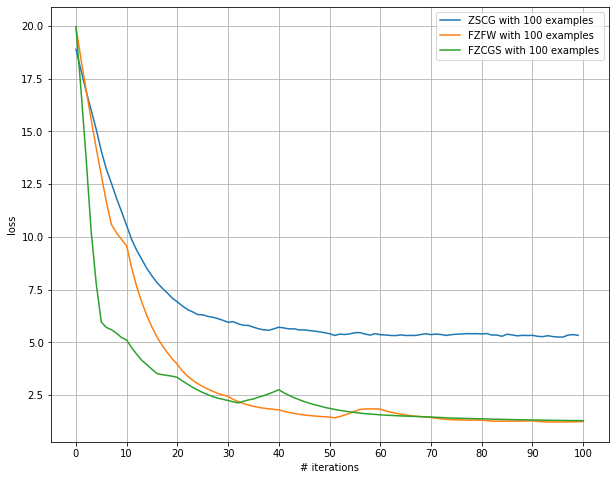

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)

In [ ]:
from tabulate import tabulate
asr_alg1=attack_success_rate(x_Z, y_true_in)
asr_alg2=attack_success_rate(x_FZ, y_true_in)
asr_alg3=attack_success_rate(x_FZC, y_true_in)


print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |        32 |
| FZFW        |        67 |
| FZF-CGS     |        63 |


[5, 29, 85, 33, 91, 82, 74, 96, 1]


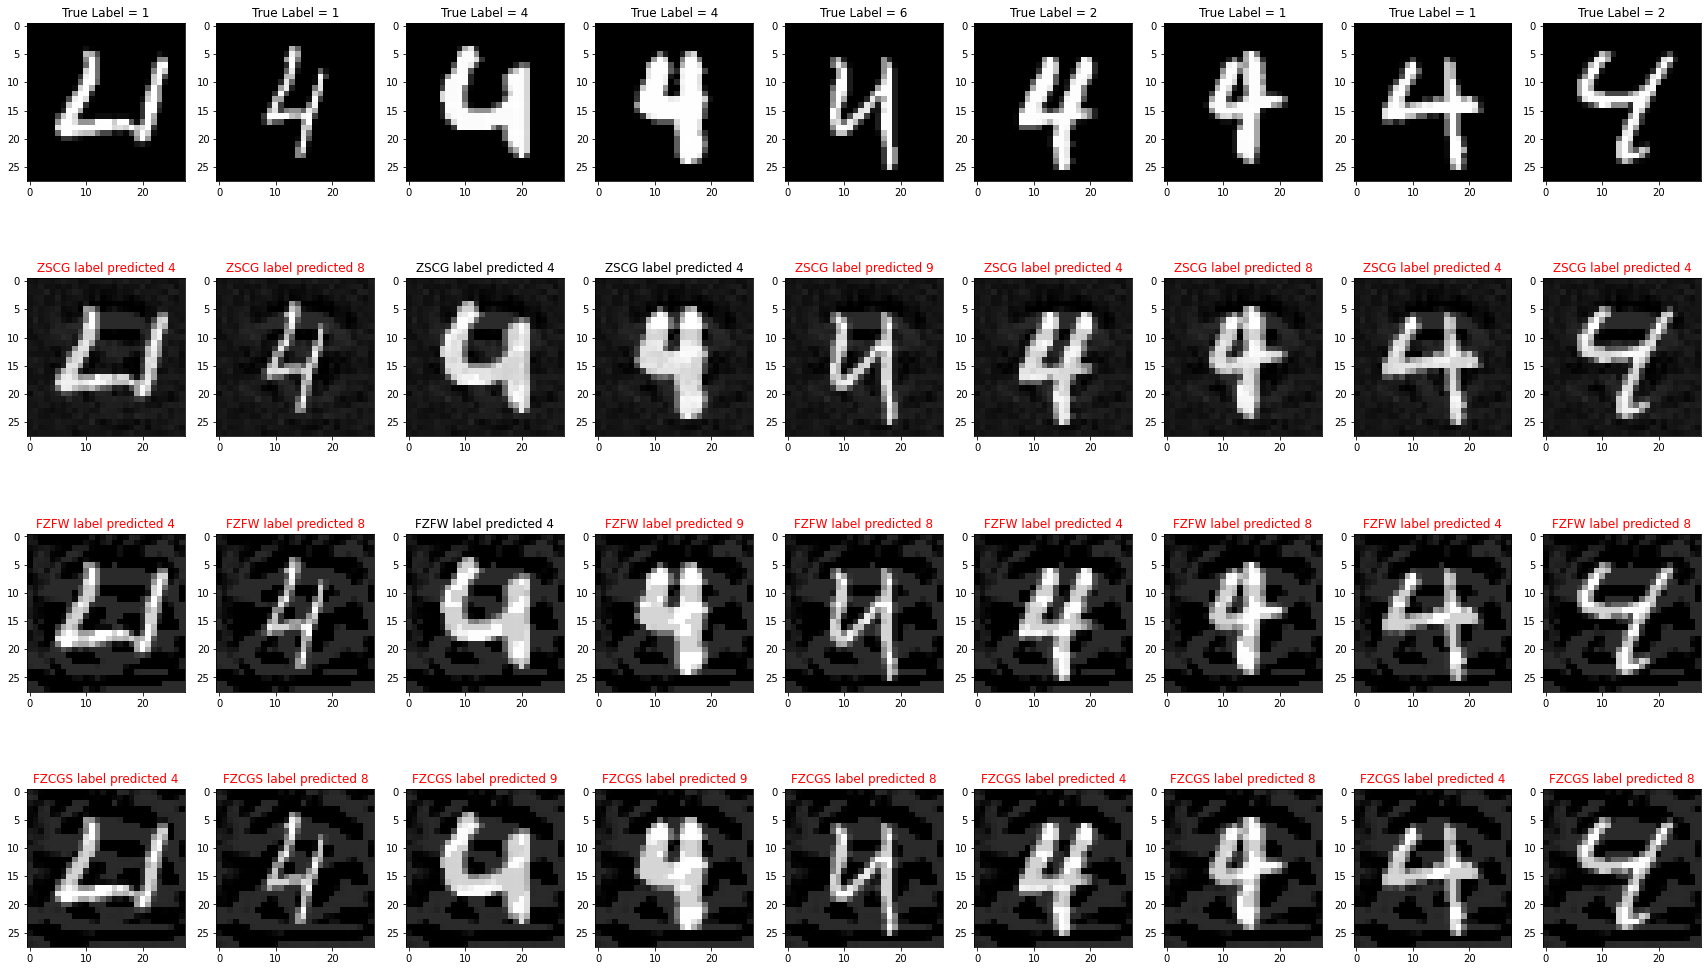

In [ ]:
n_to_show=9
idx= random.sample(range(0, n), n_to_show)
print(idx)
final = {"ZSCG": x_Z[idx], "FZFW": x_FZ[idx], "FZCGS": x_FZC[idx]}
x_toshow=x[idx]
true_label =y[idx].argmax(axis=1)

fig, ax = plt.subplots(4, n_to_show, figsize=(30,18))
for i in range(n_to_show):
  ax[0, i].imshow(x_toshow[i:i+1].reshape(28,28), cmap="gray")
  ax[0,i].set_title(f"True Label = {true_label[i]}")
row=0
for alg, data in final.items():
  row += 1
  predicted=softmax(dnn.predict(data)).argmax(axis=1)
  
  for j in range(n_to_show):
    color="black"
    ax[row, j].imshow(data[j:j+1].reshape(28,28), cmap="gray", )
    if predicted[j] != true_label[j]:
      color="red"
    ax[row, j].set_title(f"{alg} label predicted {predicted[j]}", color=color)

plt.savefig("100-examples-same-MNIST.jpg")
plt.show()


#### Examples with different class

In [ ]:
n=100
x = np.copy(x_test[:n])
x_ori=np.copy(x)
y = np.copy(y_test[:n])
epochs=200

In [ ]:
loss_Z, x_Z,_=ZSCG(epochs, 784, 0.1, 30, x, y,-1,-1, verbose=False)
loss_FZ, x_FZ,_=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y, verbose=False)
loss_FZC, x_FZC,_=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y, verbose=False)


ZSCG Final loss =  6.468831484317779
FZFW Final loss =  3.760480545759201
FZCGS Final loss =  3.6658935272693634


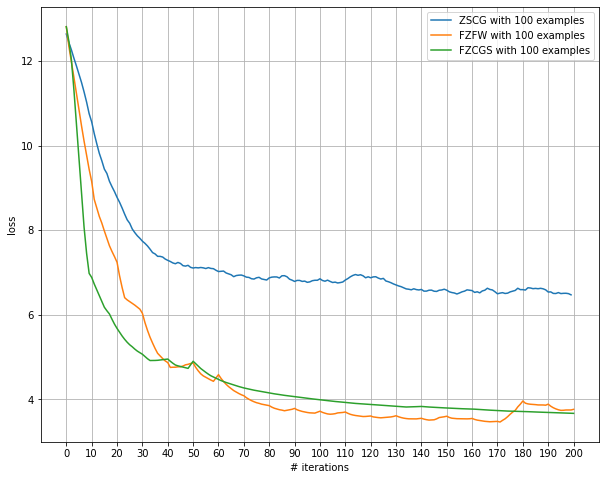

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n,savefig='100-examples-different.jpg')


In [ ]:
asr_alg1=attack_success_rate(x_Z, y)
asr_alg2=attack_success_rate(x_FZ, y)
asr_alg3=attack_success_rate(x_FZC, y)


print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |        31 |
| FZFW        |        53 |
| FZF-CGS     |        54 |


[95, 31, 58, 51, 71, 39, 41, 63, 21]


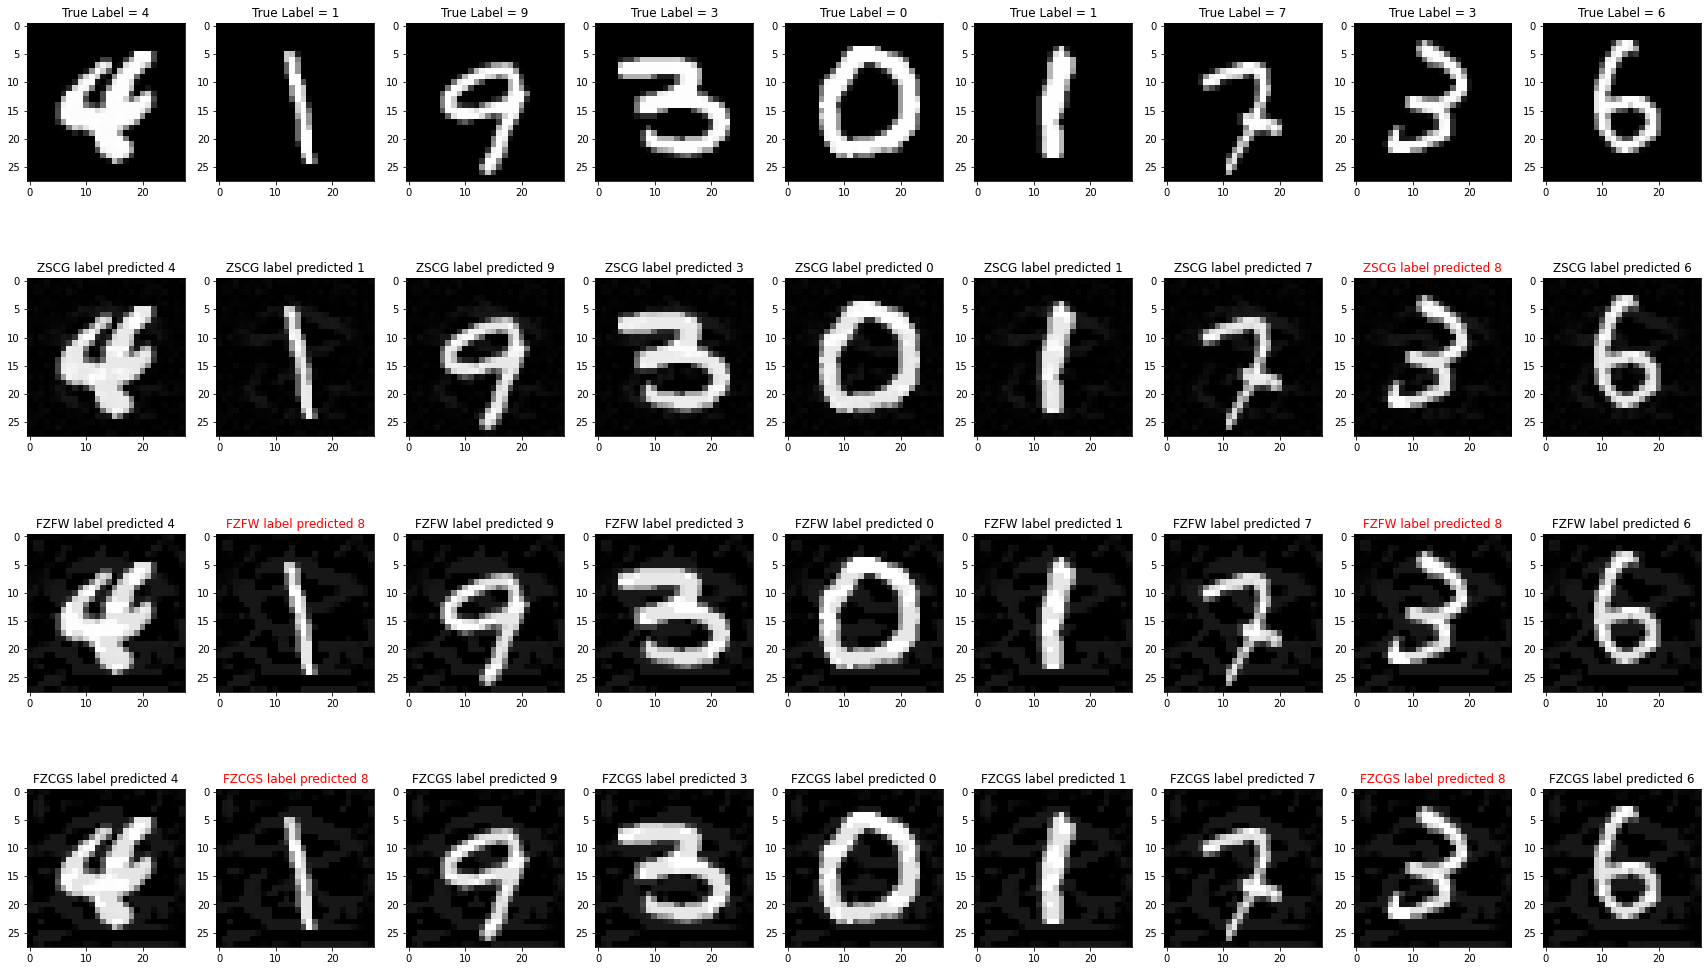

In [ ]:
n_to_show=9
idx= random.sample(range(0, n), n_to_show)
print(idx)
final = {"ZSCG": x_Z[idx], "FZFW": x_FZ[idx], "FZCGS": x_FZC[idx]}
x_toshow=x[idx]
true_label =y[idx].argmax(axis=1)

fig, ax = plt.subplots(4, n_to_show, figsize=(30,18))
for i in range(n_to_show):
  ax[0, i].imshow(x_toshow[i:i+1].reshape(28,28), cmap="gray")
  ax[0,i].set_title(f"True Label = {true_label[i]}")
row=0
for alg, data in final.items():
  row += 1
  predicted=softmax(dnn.predict(data)).argmax(axis=1)
  
  for j in range(n_to_show):
    color="black"
    ax[row, j].imshow(data[j:j+1].reshape(28,28), cmap="gray", )
    if predicted[j] != true_label[j]:
      color="red"
    ax[row, j].set_title(f"{alg} label predicted {predicted[j]}", color=color)

plt.savefig("100-examples-different-MNIST.jpg")
plt.show()


#### Final model

In [ ]:
n=36
x, _, y_true_in = get_data(n, 4)
epochs=50


In [ ]:
loss_Z, x_Z,_=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,10**-5,10**-1, verbose=True)
loss_FZ, x_FZ,_=FZFW(epochs, 784,n, 0.1,10**-1,10**-3 ,x, y_true_in, verbose=True)
loss_FZC, x_FZC,_=FZCGS(epochs, 784,n, 0.1, 10**-1,10**-1,-10**-5,x, y_true_in, verbose=True)


Epoch: 0 Loss: 20.33898996685942 Distortion: 0.0
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.89it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 20.33898996685942 Distortion: 0.02165


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 16.379014862080414 Distortion: 0.04344


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 11.955291906992594 Distortion: 0.05912


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 8.793903998202747 Distortion: 0.0714


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 6.936199572351244 Distortion: 0.08083


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 5.602800985177358 Distortion: 0.08682


100%|██████████| 36/36 [00:05<00:00,  6.75it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 4.954600837495592 Distortion: 0.08834


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 4.415787657101949 Distortion: 0.08979


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 3.970344682534536 Distortion: 0.0911


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 3.557672639687856 Distortion: 0.09234


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 3.1736324495739408 Distortion: 0.09341


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 2.8526680800649853 Distortion: 0.09446


100%|██████████| 36/36 [00:05<00:00,  6.94it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 2.5702190730306835 Distortion: 0.09486


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 2.438494861125946 Distortion: 0.09524


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 2.329078654448191 Distortion: 0.0956


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 2.2300417025883994 Distortion: 0.09594


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 2.1343256566259594 Distortion: 0.09625


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 2.0453221996625266 Distortion: 0.09657


100%|██████████| 36/36 [00:05<00:00,  6.94it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 1.954687734444936 Distortion: 0.0968


100%|██████████| 6/6 [00:01<00:00,  3.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 1.8779003752602472 Distortion: 0.09699


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 1.814307967821757 Distortion: 0.09717


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 1.757652309205797 Distortion: 0.09737


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 1.697083228164249 Distortion: 0.09753


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 1.6481432517369587 Distortion: 0.09768


100%|██████████| 36/36 [00:05<00:00,  6.80it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 1.5982263485590618 Distortion: 0.09783


100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 1.5491444799635146 Distortion: 0.09789


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 1.5843483673201666 Distortion: 0.09795


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 1.6247436205546062 Distortion: 0.098


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 1.6637449264526367 Distortion: 0.09806


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 1.697631299495697 Distortion: 0.09812


100%|██████████| 36/36 [00:05<00:00,  6.89it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 1.725937373108334 Distortion: 0.09825


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 1.6595620645417108 Distortion: 0.09836


100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 1.6032618085543315 Distortion: 0.09846


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 1.5516958369149103 Distortion: 0.09856


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 1.5005862050586276 Distortion: 0.09863


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 1.4695666895972357 Distortion: 0.0987


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 1.437612275282542 Distortion: 0.09878


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 1.395366562737359 Distortion: 0.09883


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 1.3677106830808852 Distortion: 0.09889


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 1.3404175837834675 Distortion: 0.09894


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 1.3151878118515015 Distortion: 0.09899


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 1.2923470536867778 Distortion: 0.09904


100%|██████████| 36/36 [00:05<00:00,  6.98it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 1.2699815299775865 Distortion: 0.09909


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 1.2478878762986925 Distortion: 0.09913


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 1.2260104484028287 Distortion: 0.09918


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 1.2055543396208022 Distortion: 0.09921


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 1.1902927954991658 Distortion: 0.09925


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 1.1749961574872334 Distortion: 0.09928


100%|██████████| 36/36 [00:05<00:00,  6.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 1.1611202028062608 Distortion: 0.09931


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 1.1499323447545369 Distortion: 0.09933
FZCGS Final loss =  1.1385533544752333


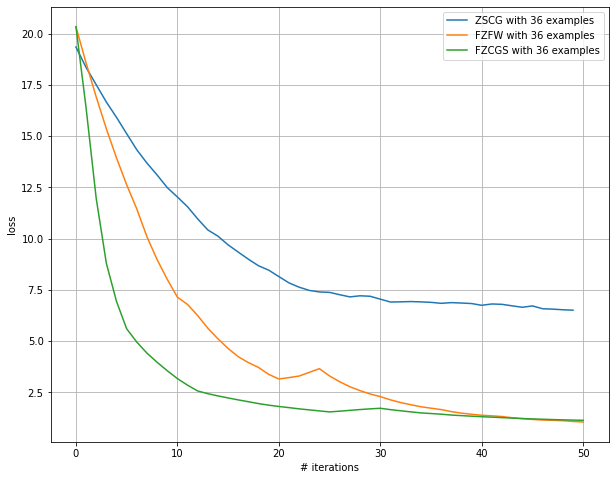

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)

In [ ]:
!pip install tabulate


In [ ]:
from tabulate import tabulate

In [ ]:
asr_alg1=attack_success_rate(x_Z, y_true_in)
asr_alg2=attack_success_rate(x_FZ, y_true_in)
asr_alg3=attack_success_rate(x_FZC, y_true_in)

print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |      25   |
| FZFW        |      69.4 |
| FZF-CGS     |      66.7 |


In [ ]:
loss_Z, x_Z,_=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,-1,-1, verbose=True)
loss_FZ, x_FZ,_=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=True)
loss_FZC, x_FZC,_=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=True)


Epoch: 0 Loss: 20.33898996685942 Distortion: 0.0


100%|██████████| 36/36 [00:02<00:00, 15.08it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 19.115417092210716 Distortion: 0.01414 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.18it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 17.9108921231495 Distortion: 0.02628 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.19it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 16.65098803759449 Distortion: 0.03671 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.11it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 15.595610548431674 Distortion: 0.04566 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.26it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 14.43329432192776 Distortion: 0.05334 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 13.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 13.55748009764486 Distortion: 0.05994 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 12.819737528761229 Distortion: 0.06561 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 12.030993264582422 Distortion: 0.07047 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 11.236997465292612 Distortion: 0.07465 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.26it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 10.45461227827602 Distortion: 0.07823 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 9.844995035065544 Distortion: 0.08131 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 9.407762855291367 Distortion: 0.08395 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 8.950222866402733 Distortion: 0.08622 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.14it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 8.538670625951555 Distortion: 0.08817 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.03it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 8.203666104210747 Distortion: 0.08984 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 7.9847309158907995 Distortion: 0.09128 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 7.743258890178469 Distortion: 0.09251 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 7.587417632341385 Distortion: 0.09357 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 7.5109944310453205 Distortion: 0.09448 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.08it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 7.410458621051577 Distortion: 0.09526 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 13.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 7.217829121483697 Distortion: 0.09593 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.04it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 7.063710331916809 Distortion: 0.09651 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 6.81386876768536 Distortion: 0.097 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 6.741590758164723 Distortion: 0.09743 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.12it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 6.561343173185985 Distortion: 0.09779 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 6.627894149886237 Distortion: 0.0981 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 6.479980316427019 Distortion: 0.09837 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 6.506828195518917 Distortion: 0.0986 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 6.582036342885759 Distortion: 0.0988 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 6.557405061191982 Distortion: 0.09897 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 6.642113539907667 Distortion: 0.09911 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.94it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 6.447968264420827 Distortion: 0.09924 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 6.6944283445676165 Distortion: 0.09935 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.78it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 6.68111225631502 Distortion: 0.09944 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 6.511847979492611 Distortion: 0.09952 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 6.374751766522725 Distortion: 0.09959 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 6.4946591589185925 Distortion: 0.09965 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 6.548872848351796 Distortion: 0.0997 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 6.66419725285636 Distortion: 0.09974 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 6.47787266307407 Distortion: 0.09978 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 6.578575167391035 Distortion: 0.09981 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 6.540086918407017 Distortion: 0.09983 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 6.526415599717034 Distortion: 0.09986 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.39it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 6.547901888688405 Distortion: 0.09988 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 6.620842410458459 Distortion: 0.0999 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 6.670947690804799 Distortion: 0.09991 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.19it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 6.730457776122623 Distortion: 0.09992 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 14.97it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 6.812527789009942 Distortion: 0.09993 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 6.58665841155582 Distortion: 0.09994 Elapsed Time:


100%|██████████| 36/36 [00:02<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 6.671154585149553 Distortion: 0.09995 Elapsed Time:
ZSCG Final loss =  6.671154585149553
Epoch: 0 Loss: 20.33898996685942 Distortion: 0.0
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.66it/s]


Epoch: 1 Loss: 17.791520320706898 Distortion: 0.01414
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch: 2 Loss: 15.549073409703043 Distortion: 0.02628
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


Epoch: 3 Loss: 13.411024626758364 Distortion: 0.03671
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch: 4 Loss: 11.670480555958218 Distortion: 0.04566
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch: 5 Loss: 10.192089978191587 Distortion: 0.05334
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch: 6 Loss: 9.16160798072815 Distortion: 0.05994
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.84it/s]


Epoch: 7 Loss: 7.661919454733531 Distortion: 0.06561
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 8 Loss: 6.56684931119283 Distortion: 0.07047
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch: 9 Loss: 5.724780009852515 Distortion: 0.07465
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch: 10 Loss: 5.038040545251635 Distortion: 0.07823
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch: 11 Loss: 4.411127103699578 Distortion: 0.08131
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 12 Loss: 3.993590149614546 Distortion: 0.08395
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.86it/s]


Epoch: 13 Loss: 3.4861702852778964 Distortion: 0.08622
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Epoch: 14 Loss: 3.1136971513430276 Distortion: 0.08817
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 15 Loss: 2.83428727918201 Distortion: 0.08984
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 16 Loss: 2.5983584920565286 Distortion: 0.09128
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch: 17 Loss: 2.3908902406692505 Distortion: 0.09251
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Epoch: 18 Loss: 2.2167881859673395 Distortion: 0.09357
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.65it/s]


Epoch: 19 Loss: 2.0010770161946616 Distortion: 0.09448
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Epoch: 20 Loss: 1.8356642325719197 Distortion: 0.09526
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 21 Loss: 1.711518989668952 Distortion: 0.09593
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Epoch: 22 Loss: 1.6306196318732367 Distortion: 0.09651
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 23 Loss: 1.5564703146616619 Distortion: 0.097
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch: 24 Loss: 1.482791715198093 Distortion: 0.09743
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.80it/s]


Epoch: 25 Loss: 1.3789486487706502 Distortion: 0.09779
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


Epoch: 26 Loss: 1.3053693771362305 Distortion: 0.0981
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch: 27 Loss: 1.239943888452318 Distortion: 0.09837
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 28 Loss: 1.1982715527216594 Distortion: 0.0986
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 29 Loss: 1.1720358663135104 Distortion: 0.0988
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch: 30 Loss: 1.1472216447194417 Distortion: 0.09897
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.83it/s]


Epoch: 31 Loss: 1.090086367395189 Distortion: 0.09911
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch: 32 Loss: 1.055629465315077 Distortion: 0.09924
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 33 Loss: 1.0387649403678045 Distortion: 0.09935
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Epoch: 34 Loss: 1.0438259177737765 Distortion: 0.09944
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch: 35 Loss: 1.0612101687325373 Distortion: 0.09952
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 36 Loss: 1.0791010989083185 Distortion: 0.09959
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.76it/s]


Epoch: 37 Loss: 1.0149385664198134 Distortion: 0.09965
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Epoch: 38 Loss: 0.9858032464981079 Distortion: 0.0997
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch: 39 Loss: 1.0311503145429823 Distortion: 0.09974
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch: 40 Loss: 1.0575802193747625 Distortion: 0.09978
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


Epoch: 41 Loss: 1.08751646677653 Distortion: 0.09981
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 42 Loss: 1.0838619735505846 Distortion: 0.09983
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch: 43 Loss: 1.024080753326416 Distortion: 0.09986
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Epoch: 44 Loss: 0.9779358704884847 Distortion: 0.09988
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch: 45 Loss: 0.9474178287718031 Distortion: 0.0999
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


Epoch: 46 Loss: 0.9308159881167941 Distortion: 0.09991
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch: 47 Loss: 0.9149583180745443 Distortion: 0.09992
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch: 48 Loss: 0.8981425629721748 Distortion: 0.09993
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.94it/s]


Epoch: 49 Loss: 0.8667532338036431 Distortion: 0.09994
----------------------------------------------------------------------------------------------------


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch: 50 Loss: 1.782159898016188 Distortion: 0.09995
----------------------------------------------------------------------------------------------------
FZFW Final loss =  1.782159898016188
Epoch: 0 Loss: 20.33898996685942 Distortion: 0.0
----------------------------------------------------------------------------------------------------


100%|██████████| 36/36 [00:05<00:00,  6.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 20.33898996685942 Distortion: 0.0308


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 14.63395762277974 Distortion: 0.05813


100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 9.262335773971346 Distortion: 0.07038


100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 7.259599947267109 Distortion: 0.07808


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 7.0602150989903345 Distortion: 0.08481


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 6.864143891466989 Distortion: 0.08932


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 7.333964748515023 Distortion: 0.09162


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 5.683697409100002 Distortion: 0.09308


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 4.788919323020512 Distortion: 0.09421


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 4.2651105059517755 Distortion: 0.09528


100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 3.845745987362332 Distortion: 0.09614


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 3.5115346444977655 Distortion: 0.09691


100%|██████████| 36/36 [00:05<00:00,  6.81it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 3.249850763214959 Distortion: 0.09723


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 3.0006975597805448 Distortion: 0.09753


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 2.791170299053192 Distortion: 0.09777


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 2.6326623227861194 Distortion: 0.09796


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 2.564935286839803 Distortion: 0.09814


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 2.520212802622053 Distortion: 0.09833


100%|██████████| 36/36 [00:05<00:00,  6.87it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 2.4823019239637585 Distortion: 0.09848


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 2.338838722970751 Distortion: 0.09863


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 2.2095754146575928 Distortion: 0.09875


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 2.1212923195627003 Distortion: 0.09887


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 2.0331321954727173 Distortion: 0.09895


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 1.9858328104019165 Distortion: 0.09903


100%|██████████| 36/36 [00:05<00:00,  6.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 1.9338964223861694 Distortion: 0.09909


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 1.8695705466800265 Distortion: 0.09916


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 1.8100368579228718 Distortion: 0.09922


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 1.7581328948338826 Distortion: 0.09928


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 1.7024810049268935 Distortion: 0.09933


100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 1.6538116799460516 Distortion: 0.09938


100%|██████████| 36/36 [00:05<00:00,  6.87it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 1.6082614925172594 Distortion: 0.09942


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 1.5503572622934978 Distortion: 0.09946


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 1.500259280204773 Distortion: 0.0995


100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 1.5582541359795465 Distortion: 0.09953


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 1.6294080813725789 Distortion: 0.09956


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 1.6741897265116374 Distortion: 0.09959


100%|██████████| 36/36 [00:05<00:00,  6.96it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 1.7483495473861694 Distortion: 0.09963


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 1.6382761398951213 Distortion: 0.09965


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 1.7508669164445665 Distortion: 0.09969


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 1.6612396902508206 Distortion: 0.09972


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 1.581400473912557 Distortion: 0.09975


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 1.5090804894765217 Distortion: 0.09976


100%|██████████| 36/36 [00:05<00:00,  6.86it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 1.6401518318388197 Distortion: 0.09978


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 1.552923732333713 Distortion: 0.0998


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 1.4922762049569025 Distortion: 0.09982


100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 1.4424959553612604 Distortion: 0.09983


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 1.401583366923862 Distortion: 0.09984


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 1.3681790961159601 Distortion: 0.09985


100%|██████████| 36/36 [00:05<00:00,  6.98it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 1.339891062842475 Distortion: 0.09986


100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 1.3096224466959636 Distortion: 0.09987
FZCGS Final loss =  1.459165374437968


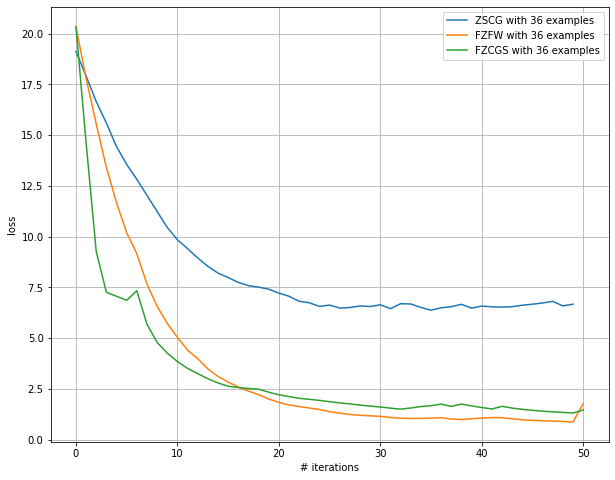

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)

In [ ]:
asr_alg1=attack_success_rate(x_Z, y_true_in)
asr_alg2=attack_success_rate(x_FZ, y_true_in)
asr_alg3=attack_success_rate(x_FZC, y_true_in)


print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |      25   |
| FZFW        |      55.6 |
| FZF-CGS     |      66.7 |


### Hyperparams


#### Algorithm 1

In [ ]:
n=36
x, _, y_true_in = get_data(n, 4)
epochs=50

In [ ]:
v_list = [10**-1,10**-3,10**-5,10**-7,10**-9]
alpha_list= [10**-1,10**-3,10**-5,10**-6,10**-7]
loss_ZSCG_all = []
x_ZSCG_all = []
epochs=50
for v in v_list:
  for alpha in alpha_list: 
    print(f"Computing ZSCG with v = {v} and alpha = {alpha}")
    loss_Z, x_Z,_=ZSCG(epochs, 784, 0.1, 30, x, y_true_in, v, alpha, verbose=False)
    loss_ZSCG_all.append(loss_Z)
    x_ZSCG_all.append(x_Z)




Computing ZSCG with v = 0.1 and alpha = 0.1
ZSCG Final loss =  7.515151527192858
Computing ZSCG with v = 0.1 and alpha = 0.001
ZSCG Final loss =  20.00124193769362
Computing ZSCG with v = 0.1 and alpha = 1e-05
ZSCG Final loss =  20.335629750043154
Computing ZSCG with v = 0.1 and alpha = 1e-06
ZSCG Final loss =  20.33863937565022
Computing ZSCG with v = 0.1 and alpha = 1e-07
ZSCG Final loss =  20.338955108076334
Computing ZSCG with v = 0.001 and alpha = 0.1
ZSCG Final loss =  6.453881594869825
Computing ZSCG with v = 0.001 and alpha = 0.001
ZSCG Final loss =  19.88409943588906
Computing ZSCG with v = 0.001 and alpha = 1e-05
ZSCG Final loss =  20.33462751780947
Computing ZSCG with v = 0.001 and alpha = 1e-06
ZSCG Final loss =  20.33854905805654
Computing ZSCG with v = 0.001 and alpha = 1e-07
ZSCG Final loss =  20.338946781638597
Computing ZSCG with v = 1e-05 and alpha = 0.1
ZSCG Final loss =  6.837021681997511
Computing ZSCG with v = 1e-05 and alpha = 0.001
ZSCG Final loss =  19.87542732

In [ ]:
table_ZSCG = nice_table(x_ZSCG_all, y_true_in, ("V", v_list), ("Alpha", alpha_list))
print(table_ZSCG)

+--------+--------+---------+
|   V    | Alpha  | ASR (%) |
+--------+--------+---------+
|   0.1  |   0.1  |   16.7  |
|   0.1  |  0.001 |   0.0   |
|   0.1  |  1e-05 |   0.0   |
|   0.1  |  1e-06 |   0.0   |
|   0.1  |  1e-07 |   0.0   |
|  0.001 |   0.1  |   19.4  |
|  0.001 |  0.001 |   0.0   |
|  0.001 |  1e-05 |   0.0   |
|  0.001 |  1e-06 |   0.0   |
|  0.001 |  1e-07 |   0.0   |
|  1e-05 |   0.1  |   22.2  |
|  1e-05 |  0.001 |   0.0   |
|  1e-05 |  1e-05 |   0.0   |
|  1e-05 |  1e-06 |   0.0   |
|  1e-05 |  1e-07 |   0.0   |
|  1e-07 |   0.1  |   2.8   |
|  1e-07 |  0.001 |   0.0   |
|  1e-07 |  1e-05 |   0.0   |
|  1e-07 |  1e-06 |   0.0   |
|  1e-07 |  1e-07 |   0.0   |
|  1e-09 |   0.1  |   0.0   |
|  1e-09 |  0.001 |   0.0   |
|  1e-09 |  1e-05 |   0.0   |
|  1e-09 |  1e-06 |   0.0   |
|  1e-09 |  1e-07 |   0.0   |
+--------+--------+---------+


In [ ]:
v_test_list=[10**-1, 10**-3, 10**-5, 10**-7]
loss_list = []
x_Z_list=[]
for v_el in v_test_list:
  l, x_Z_new,_=ZSCG(epochs, 784, 0.1, 30, x, y_true_in, v=v_el, alpha=10**-1, verbose=True)
  loss_list.append(l)
  x_Z_list.append(x_Z_new)

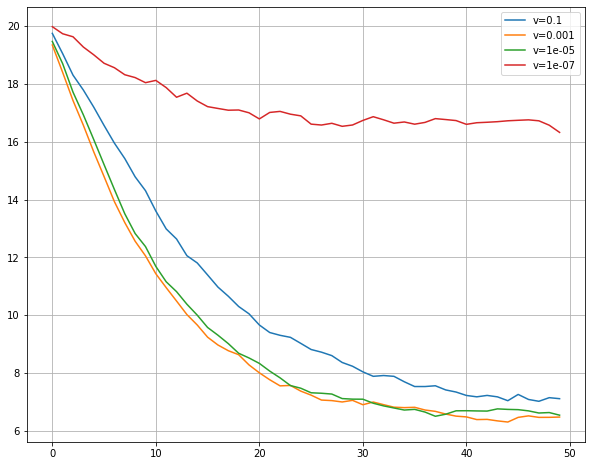

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(loss_list)):
  plt.plot(loss_list[i], label =f"v={v_test_list[i]}")  
  plt.grid("on")
  plt.legend()
plt.savefig("zscg_different_params.jpg")
plt.show()

#### Algorithm 2

In [ ]:
gamma_list = [10**-1,10**-3,10**-5,10**-7]
mu_list= [10**-1,10**-3,10**-5,10**-7]
loss_FZFW_all = []
x_FZFW_all = []
epochs=50
for gamma in gamma_list:
  for mu in mu_list: 
    print(f"Computing FZFW with gamma = {gamma} and mu = {mu}")
    loss_FZFW, x_FZFW, _=FZFW(epochs, 784, n,0.1,  gamma, mu,x, y_true_in, verbose=False)
    loss_FZFW_all.append(loss_FZFW)
    x_FZFW_all.append(x_FZFW)



Computing FZFW with gamma = 0.1 and mu = 0.1
FZFW Final loss =  1.1300671762890286
Computing FZFW with gamma = 0.1 and mu = 0.001
FZFW Final loss =  1.3266793886820476
Computing FZFW with gamma = 0.1 and mu = 1e-05
FZFW Final loss =  3.257648958100213
Computing FZFW with gamma = 0.1 and mu = 1e-07
FZFW Final loss =  19.477879385153454
Computing FZFW with gamma = 0.001 and mu = 0.1
FZFW Final loss =  19.484923822598326
Computing FZFW with gamma = 0.001 and mu = 0.001
FZFW Final loss =  19.467675282309454
Computing FZFW with gamma = 0.001 and mu = 1e-05
FZFW Final loss =  19.638891369518305
Computing FZFW with gamma = 0.001 and mu = 1e-07
FZFW Final loss =  20.318421996715998
Computing FZFW with gamma = 1e-05 and mu = 0.1
FZFW Final loss =  20.330417411608828
Computing FZFW with gamma = 1e-05 and mu = 0.001
FZFW Final loss =  20.33038969213764
Computing FZFW with gamma = 1e-05 and mu = 1e-05
FZFW Final loss =  20.331921766615576
Computing FZFW with gamma = 1e-05 and mu = 1e-07
FZFW Final

In [ ]:
table_FZFW = nice_table(x_FZFW_all, y_true_in, ("Gamma", gamma_list), ("Mu", mu_list))
print(table_FZFW)

+--------+--------+---------+
| Gamma  |   Mu   | ASR (%) |
+--------+--------+---------+
|   0.1  |   0.1  |   61.1  |
|   0.1  |  0.001 |   69.4  |
|   0.1  |  1e-05 |   47.2  |
|   0.1  |  1e-07 |   0.0   |
|  0.001 |   0.1  |   0.0   |
|  0.001 |  0.001 |   0.0   |
|  0.001 |  1e-05 |   0.0   |
|  0.001 |  1e-07 |   0.0   |
|  1e-05 |   0.1  |   0.0   |
|  1e-05 |  0.001 |   0.0   |
|  1e-05 |  1e-05 |   0.0   |
|  1e-05 |  1e-07 |   0.0   |
|  1e-07 |   0.1  |   0.0   |
|  1e-07 |  0.001 |   0.0   |
|  1e-07 |  1e-05 |   0.0   |
|  1e-07 |  1e-07 |   0.0   |
+--------+--------+---------+


In [ ]:
mu_test_list=[10**-1, 10**-3, 10**-5]
loss_list = []
x_F_list=[]
for mu_el in mu_test_list:
  l, x_F_new,_=FZFW(epochs, 784, n,0.1,  gamma=0.1, mu=mu_el,x=x, y_true_in=y_true_in, verbose=True)
  loss_list.append(l)
  x_F_list.append(x_F_new)

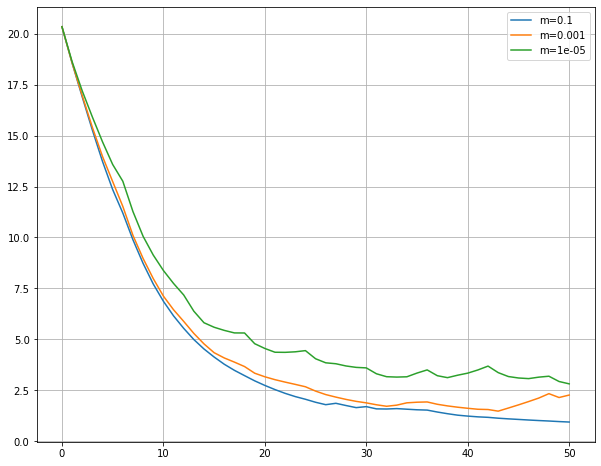

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(loss_list)):
  plt.plot(loss_list[i], label =f"mu={mu_test_list[i]}")  
  plt.grid("on")
  plt.legend()
plt.savefig("fzfw_different_params.jpg")
plt.show()

#### Algorithm 3

In [ ]:
eta_list= [10**-1,10**-3,10**-5,10**-7]

loss_FZCGS_all = []
x_FZCGS_all = []
epochs=50
gamma_final = 0.1
mu_final = [10**-1, 10**-3, 10**-5]
for mu in mu_final:
  for eta in eta_list: 
    print(f"Computing FZFW with gamma = {gamma_final} , mu = {mu} and eta = {eta}")
    loss_FZCGS, x_FZCGS,_=FZCGS(epochs, 784, n,0.1, gamma_final, mu, eta, x, y_true_in,verbose=False)
    loss_FZCGS_all.append(loss_FZCGS)
    x_FZCGS_all.append(x_FZCGS)



Computing FZFW with gamma = 0.1 , mu = 0.1 and eta = 0.1
FZCGS Final loss =  1.033313340610928
Computing FZFW with gamma = 0.1 , mu = 0.1 and eta = 0.001
FZCGS Final loss =  1.1308283938301935
Computing FZFW with gamma = 0.1 , mu = 0.1 and eta = 1e-05
FZCGS Final loss =  1.0278937286800809
Computing FZFW with gamma = 0.1 , mu = 0.1 and eta = 1e-07
FZCGS Final loss =  0.9748348924848769
Computing FZFW with gamma = 0.1 , mu = 0.001 and eta = 0.1
FZCGS Final loss =  1.3585516346825495
Computing FZFW with gamma = 0.1 , mu = 0.001 and eta = 0.001
FZCGS Final loss =  1.3739580644501581
Computing FZFW with gamma = 0.1 , mu = 0.001 and eta = 1e-05
FZCGS Final loss =  1.5551652842097812
Computing FZFW with gamma = 0.1 , mu = 0.001 and eta = 1e-07
FZCGS Final loss =  1.3321527573797438
Computing FZFW with gamma = 0.1 , mu = 1e-05 and eta = 0.1
FZCGS Final loss =  3.2098620202806263
Computing FZFW with gamma = 0.1 , mu = 1e-05 and eta = 0.001
FZCGS Final loss =  3.0028761823972068
Computing FZFW 

In [ ]:
table_FZCGS = nice_table(x_FZCGS_all, y_true_in, ("Mu", mu_list), ("Eta", eta_list),)
print(table_FZCGS)

+--------+--------+---------+
|   Mu   |  Eta   | ASR (%) |
+--------+--------+---------+
|   0.1  |   0.1  |   63.9  |
|   0.1  |  0.001 |   63.9  |
|   0.1  |  1e-05 |   69.4  |
|   0.1  |  1e-07 |   66.7  |
|  0.001 |   0.1  |   66.7  |
|  0.001 |  0.001 |   66.7  |
|  0.001 |  1e-05 |   66.7  |
|  0.001 |  1e-07 |   69.4  |
|  1e-05 |   0.1  |   52.8  |
|  1e-05 |  0.001 |   47.2  |
|  1e-05 |  1e-05 |   38.9  |
|  1e-05 |  1e-07 |   52.8  |
+--------+--------+---------+


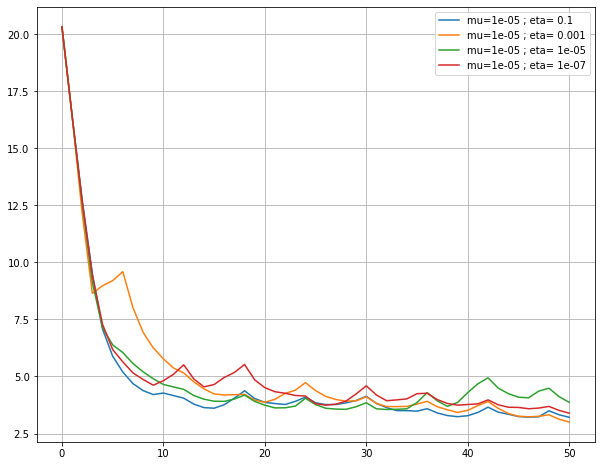

In [ ]:
plt.figure(figsize=(10,8))
j=0
for i in range(4):
    plt.plot(loss_FZCGS_all[i+8], label =f"mu={mu_final[2]} ; eta= {eta_list[i]}")  
    plt.grid("on")
    plt.legend()
plt.savefig("fzscg_different_params_3.jpg")
plt.show()

### Different mk

In [ ]:
n=16
x, _, y_true_in = get_data(n, 4)
epochs=50



In [ ]:
F(x, y_true_in)


21.861107007600367

In [ ]:
q= [1,10,20,30,100]
loss_all_q = []
x_pert_q = []
pert_q = []
for elq in q:
  loss_Z, x_Z, p1=ZSCG(epochs, 784, 0.1,elq, x, y_true_in,verbose=True)
  loss_all_q.append(loss_Z)
  x_pert_q.append(x_Z)
  pert_q.append(p1)



Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 15.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 21.861107007600367 Distortion: 0.01414 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 21.407895836047828 Distortion: 0.02628 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 21.235906433314085 Distortion: 0.03671 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 21.189406543970108 Distortion: 0.04566 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 20.929756364785135 Distortion: 0.05334 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 20.581906914711 Distortion: 0.05994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 20.742997892200947 Distortion: 0.06561 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 20.865629605948925 Distortion: 0.07047 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.66it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 20.62659677118063 Distortion: 0.07465 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 20.472420014441013 Distortion: 0.07823 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.58it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 20.171220041811466 Distortion: 0.07515 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 20.080435179173946 Distortion: 0.07867 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 19.86981787532568 Distortion: 0.08168 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 19.53872510790825 Distortion: 0.08428 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 19.31296256184578 Distortion: 0.0865 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.61it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 19.358097046613693 Distortion: 0.07978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.61it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 19.838645361363888 Distortion: 0.08264 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 19.656410194933414 Distortion: 0.08509 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 19.85105559974909 Distortion: 0.0872 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.72it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 19.962963107042015 Distortion: 0.07684 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 19.954486034810543 Distortion: 0.08012 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 19.76093892008066 Distortion: 0.08293 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 20.05086676031351 Distortion: 0.08534 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 19.818395536392927 Distortion: 0.08562 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 19.60320220887661 Distortion: 0.08765 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 19.335021913051605 Distortion: 0.0894 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 19.274559572339058 Distortion: 0.07856 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.75it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 19.22613949328661 Distortion: 0.0816 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 19.22989249229431 Distortion: 0.0842 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.66it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 19.27261207252741 Distortion: 0.08643 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 19.414826549589634 Distortion: 0.08224 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 19.40779060870409 Distortion: 0.07575 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 19.614903159439564 Distortion: 0.07838 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 19.687210880219936 Distortion: 0.08109 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.67it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 19.810089200735092 Distortion: 0.08317 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 19.55734347552061 Distortion: 0.08119 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 19.691901467740536 Distortion: 0.08385 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 19.57146792113781 Distortion: 0.08614 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 19.51935449242592 Distortion: 0.0881 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.69it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 19.468934081494808 Distortion: 0.08978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 19.67053657770157 Distortion: 0.09123 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 19.513806365430355 Distortion: 0.07891 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.62it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 19.596377357840538 Distortion: 0.07828 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.78it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 19.670728862285614 Distortion: 0.07925 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 19.37816884368658 Distortion: 0.08057 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 19.318923510611057 Distortion: 0.08332 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 19.264076970517635 Distortion: 0.07898 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 19.41550486534834 Distortion: 0.08077 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 19.567854307591915 Distortion: 0.08349 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 19.401433534920216 Distortion: 0.0808 Elapsed Time:
ZSCG Final loss =  19.468826971948147
Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 21.861107007600367 Distortion: 0.01414 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 21.04939980339259 Distortion: 0.02628 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 20.50929342955351 Distortion: 0.03671 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 19.527188897132874 Distortion: 0.04566 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 18.906144849956036 Distortion: 0.05334 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 18.255115926265717 Distortion: 0.05994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 17.798126734793186 Distortion: 0.06561 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 17.46017261594534 Distortion: 0.07047 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 16.868935242295265 Distortion: 0.07465 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.27it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 16.627195596694946 Distortion: 0.07823 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.62it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 16.069057449698448 Distortion: 0.08131 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 15.863065391778946 Distortion: 0.08395 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.68it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 15.535898044705391 Distortion: 0.08622 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 15.206646040081978 Distortion: 0.08817 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.58it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 14.812157765030861 Distortion: 0.08984 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 14.654165655374527 Distortion: 0.09128 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 14.583502404391766 Distortion: 0.09251 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 14.47157770395279 Distortion: 0.09111 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.58it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 14.301156356930733 Distortion: 0.09236 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 14.038055695593357 Distortion: 0.09344 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 14.159617207944393 Distortion: 0.09437 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 14.449486210942268 Distortion: 0.09517 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 14.220691002905369 Distortion: 0.09585 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 13.971593104302883 Distortion: 0.09644 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.76it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 13.660553775727749 Distortion: 0.09694 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.67it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 13.343437150120735 Distortion: 0.09737 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 13.068520739674568 Distortion: 0.09752 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.65it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 13.293804876506329 Distortion: 0.09787 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 13.441664390265942 Distortion: 0.09817 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 13.204543299973011 Distortion: 0.09843 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.12it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 13.244620330631733 Distortion: 0.09865 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 13.370686545968056 Distortion: 0.09884 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.72it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 13.348620034754276 Distortion: 0.09901 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 13.261079132556915 Distortion: 0.09915 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 13.273401767015457 Distortion: 0.09927 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 12.859883457422256 Distortion: 0.09937 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 12.80579674243927 Distortion: 0.09946 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 12.686031565070152 Distortion: 0.09954 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 12.783869341015816 Distortion: 0.0996 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 12.734492242336273 Distortion: 0.09966 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 12.752224698662758 Distortion: 0.09971 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.63it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 13.008017681539059 Distortion: 0.09975 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.40it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 12.90014735609293 Distortion: 0.09978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.65it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 12.943977601826191 Distortion: 0.09981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.06it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 12.686910443007946 Distortion: 0.09984 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 12.744536988437176 Distortion: 0.09986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.19it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 12.785269118845463 Distortion: 0.09988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 12.698024183511734 Distortion: 0.0999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 12.776719525456429 Distortion: 0.09991 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 12.872988171875477 Distortion: 0.09993 Elapsed Time:
ZSCG Final loss =  12.984017752110958
Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 14.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 21.861107007600367 Distortion: 0.01414 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 20.89362606406212 Distortion: 0.02628 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.18it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 19.86442854255438 Distortion: 0.03671 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 18.72127790004015 Distortion: 0.04566 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 17.77038048952818 Distortion: 0.05334 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 16.95049150288105 Distortion: 0.05994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 16.409454502165318 Distortion: 0.06561 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 15.689227141439915 Distortion: 0.07047 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.14it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 15.409539878368378 Distortion: 0.07465 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.00it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 14.951920486986637 Distortion: 0.07823 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.67it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 14.460633963346481 Distortion: 0.08131 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 14.124277547001839 Distortion: 0.08395 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 13.760764934122562 Distortion: 0.08622 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.90it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 13.505385048687458 Distortion: 0.08817 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 13.025658704340458 Distortion: 0.08984 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 12.657981045544147 Distortion: 0.09128 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 12.574412681162357 Distortion: 0.09251 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 12.391224332153797 Distortion: 0.09357 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 12.415176540613174 Distortion: 0.09448 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 12.07269960641861 Distortion: 0.09526 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 11.9983299523592 Distortion: 0.09593 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 11.754643604159355 Distortion: 0.09651 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 11.466165125370026 Distortion: 0.097 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 11.238093242049217 Distortion: 0.09743 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 11.119510263204575 Distortion: 0.09779 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 11.144277930259705 Distortion: 0.0981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.14it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 10.966180548071861 Distortion: 0.09837 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 10.89531584084034 Distortion: 0.0986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.93it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 11.076078966259956 Distortion: 0.0988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.62it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 10.853617832064629 Distortion: 0.09897 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.00it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 10.471893653273582 Distortion: 0.09911 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 10.193574026226997 Distortion: 0.09924 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 10.213736459612846 Distortion: 0.09935 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 10.294601500034332 Distortion: 0.09944 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 10.256962299346924 Distortion: 0.09952 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.39it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 10.302358135581017 Distortion: 0.09959 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 10.23366728425026 Distortion: 0.09965 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.85it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 10.176761463284492 Distortion: 0.0997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 10.173283234238625 Distortion: 0.09974 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 10.274246945977211 Distortion: 0.09978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 10.045728012919426 Distortion: 0.09981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 9.949279814958572 Distortion: 0.09983 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 9.979090183973312 Distortion: 0.09986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 9.898200362920761 Distortion: 0.09988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.26it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 9.825787350535393 Distortion: 0.0999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 9.792528197169304 Distortion: 0.09991 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.89it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 9.721834421157837 Distortion: 0.09992 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 9.720065101981163 Distortion: 0.09993 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.16it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 9.608597949147224 Distortion: 0.09994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 9.707244202494621 Distortion: 0.09995 Elapsed Time:
ZSCG Final loss =  9.782977774739265
Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 21.861107007600367 Distortion: 0.01414 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 20.57876689080149 Distortion: 0.02628 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 19.41366719454527 Distortion: 0.03671 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 18.180005207657814 Distortion: 0.04566 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 16.997822426259518 Distortion: 0.05334 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.19it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 16.11605455726385 Distortion: 0.05994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 15.41926633566618 Distortion: 0.06561 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 14.868457406759262 Distortion: 0.07047 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.06it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 13.856981329619884 Distortion: 0.07465 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 13.28193411976099 Distortion: 0.07823 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.08it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 12.76308486610651 Distortion: 0.08131 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 12.557091169059277 Distortion: 0.08395 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.07it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 12.108500689268112 Distortion: 0.08622 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 11.634057350456715 Distortion: 0.08817 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 11.219886921346188 Distortion: 0.08984 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 10.910362496972084 Distortion: 0.09128 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 11.054417341947556 Distortion: 0.09251 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 10.649760693311691 Distortion: 0.09357 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.27it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 10.272448062896729 Distortion: 0.09448 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 10.256327882409096 Distortion: 0.09526 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 10.136380985379219 Distortion: 0.09593 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 9.76448954641819 Distortion: 0.09651 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 9.59365451335907 Distortion: 0.097 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.92it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 9.316800698637962 Distortion: 0.09743 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 9.242494136095047 Distortion: 0.09779 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.11it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 8.97236117720604 Distortion: 0.0981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 9.079906016588211 Distortion: 0.09837 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 9.045205011963844 Distortion: 0.0986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.78it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 9.184326991438866 Distortion: 0.0988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 8.989590853452682 Distortion: 0.09897 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 8.79515253007412 Distortion: 0.09911 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 8.859202340245247 Distortion: 0.09924 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 8.913073137402534 Distortion: 0.09935 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.63it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 8.943673878908157 Distortion: 0.09944 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 8.888813018798828 Distortion: 0.09952 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.01it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 8.880616262555122 Distortion: 0.09959 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 8.616034552454948 Distortion: 0.09965 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 8.725633427500725 Distortion: 0.0997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.26it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 8.938932463526726 Distortion: 0.09974 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.23it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 9.229795917868614 Distortion: 0.09978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 9.09607818722725 Distortion: 0.09981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 8.953957095742226 Distortion: 0.09983 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 8.994870781898499 Distortion: 0.09986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 8.729466810822487 Distortion: 0.09988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.70it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 8.757415011525154 Distortion: 0.0999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 8.892854630947113 Distortion: 0.09991 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 8.86855761706829 Distortion: 0.09992 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.05it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 8.789628431200981 Distortion: 0.09993 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 8.898590713739395 Distortion: 0.09994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 8.776669651269913 Distortion: 0.09995 Elapsed Time:
ZSCG Final loss =  8.868378043174744
Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 13.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 21.861107007600367 Distortion: 0.01414 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.92it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 19.93276307731867 Distortion: 0.02628 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.80it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 18.424181170761585 Distortion: 0.03671 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.70it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 16.889543630182743 Distortion: 0.04566 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.62it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 15.314061656594276 Distortion: 0.05334 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.69it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 13.887971244752407 Distortion: 0.05994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.76it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 12.677257418632507 Distortion: 0.06561 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 11.756116814911366 Distortion: 0.07047 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 10.74161110818386 Distortion: 0.07465 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.03it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 10.078460291028023 Distortion: 0.07823 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.77it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 9.309572875499725 Distortion: 0.08131 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 11.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 8.81502828001976 Distortion: 0.08395 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.67it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 8.241860911250114 Distortion: 0.08622 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.58it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 7.858513832092285 Distortion: 0.08817 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 7.497596830129623 Distortion: 0.08984 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 7.205743491649628 Distortion: 0.09128 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 7.000995293259621 Distortion: 0.09251 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.78it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 6.942207500338554 Distortion: 0.09357 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 6.812132030725479 Distortion: 0.09448 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.74it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 6.774893701076508 Distortion: 0.09526 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 6.584932819008827 Distortion: 0.09593 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.75it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 6.549454003572464 Distortion: 0.09651 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 6.514312878251076 Distortion: 0.097 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.75it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 6.460181638598442 Distortion: 0.09743 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.63it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 6.510758250951767 Distortion: 0.09779 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 6.517611801624298 Distortion: 0.0981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.63it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 6.436180129647255 Distortion: 0.09837 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.70it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 6.289110422134399 Distortion: 0.0986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 11.96it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 6.298346072435379 Distortion: 0.0988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.52it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 6.292785063385963 Distortion: 0.09897 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 6.2695464342832565 Distortion: 0.09911 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.71it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 6.18921235203743 Distortion: 0.09924 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.14it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 6.26931993663311 Distortion: 0.09935 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.72it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 6.252798393368721 Distortion: 0.09944 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 6.143838971853256 Distortion: 0.09952 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.00it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 6.041768461465836 Distortion: 0.09959 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 6.002420872449875 Distortion: 0.09965 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.65it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 6.032175600528717 Distortion: 0.0997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.66it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 5.972856178879738 Distortion: 0.09974 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 6.043731689453125 Distortion: 0.09978 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 6.0508143454790115 Distortion: 0.09981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 6.22409588098526 Distortion: 0.09983 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 6.166663125157356 Distortion: 0.09986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 6.221178710460663 Distortion: 0.09988 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 11.57it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 6.164899826049805 Distortion: 0.0999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 6.1242987513542175 Distortion: 0.09991 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.08it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 6.232956916093826 Distortion: 0.09992 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 6.342871218919754 Distortion: 0.09993 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.40it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 6.326717376708984 Distortion: 0.09994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.87it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 6.27521339058876 Distortion: 0.09995 Elapsed Time:
ZSCG Final loss =  6.191715896129608


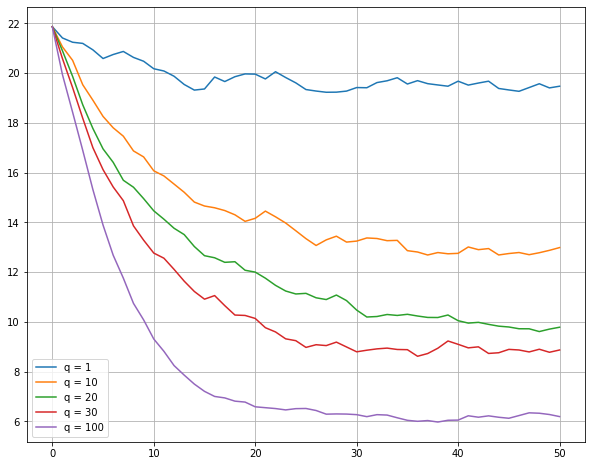

In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(loss_all_q)):
  plt.plot(loss_all_q[i],label=f"q = {q[i]}" )
  plt.grid("on")
  plt.legend()

plt.savefig("")
plt.show()

In [ ]:
n=16
x = np.copy(x_test[:n])
x_ori=np.copy(x)
y_true_in = np.copy(y_test[:n])
epochs=50

In [ ]:
F(x, y_true_in)


In [ ]:
q= [1,10,20,30,100]
loss_all_q = []
x_pert_q = []
pert_q = []
for elq in q:
  loss_Z, x_Z, p1=ZSCG(epochs, 784, 0.1,elq, x, y_true_in,verbose=True)
  loss_all_q.append(loss_Z)
  x_pert_q.append(x_Z)
  pert_q.append(p1)



In [ ]:
plt.figure(figsize=(10,8))
for i in range(len(loss_all_q)):
  plt.plot(loss_all_q[i],label=f"q = {q[i]}" )
  plt.grid("on")
  plt.legend()

plt.savefig("")
plt.show()

#### Clip vs No Clip

In [ ]:
n=16
x, _, y_true_in = get_data(n, 4)
epochs=50



In [ ]:
loss_Z, x_Z,_=ZSCG(epochs, 784, 0.1, 30, x, y,-1,-1, verbose=True, clip = True)
loss_FZ, x_FZ,_=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y, verbose=True, clip = True)
loss_FZC, x_FZC,_=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y, verbose=True, clip = True)


#### attack ZSCg woth q = 1 and increasing sample size

In [ ]:
size= [16,128, 256,512]

epochs=50


loss_all_q = []
x_pert_q = []
pert_q = []
for elsize in size:
  n=elsize
  x, _, y_true_in = get_data(n, 4)
  loss_Z, x_Z, p1=ZSCG(epochs, 784, 0.1,1, x, y_true_in,verbose=True)
  loss_all_q.append(loss_Z)
  x_pert_q.append(x_Z)
  pert_q.append(p1)



In [ ]:
# loss_FZ, x_FZ,p2=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=True)
# loss_FZC, x_FZC,p3=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=True)

### Change Distorsion

#### Distorsion = 0.2

In [ ]:
n=16
x, _, y_true_in = get_data(n, 4)
epochs=100

In [ ]:
loss_Z, x_Z=ZSCG(epochs, 784, 0.2, 30, x, y_true_in, verbose=True)
loss_FZ, x_FZ=FZFW(epochs, 784,n, 0.2, x, y_true_in, verbose=True)
loss_FZC, x_FZC=FZCGS(epochs, 784,n, 0.2, x, y_true_in, verbose=True)


Epoch: 0 Loss: 21.861107007600367 Distortion: 0.0


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1 Loss: 19.98285746574402 Distortion: 0.02 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2 Loss: 18.0840051099658 Distortion: 0.038 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.27it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3 Loss: 16.216815315186977 Distortion: 0.0542 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4 Loss: 14.389096334576607 Distortion: 0.06878 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5 Loss: 12.673282042145729 Distortion: 0.0819 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6 Loss: 11.225858815014362 Distortion: 0.09371 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7 Loss: 9.79150502383709 Distortion: 0.10434 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8 Loss: 8.20074525475502 Distortion: 0.11391 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9 Loss: 7.158475920557976 Distortion: 0.12252 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.37it/s]


----------------------------------------------------------------------------------------------------
Epoch: 10 Loss: 6.291060879826546 Distortion: 0.13026 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 11 Loss: 5.956684052944183 Distortion: 0.13724 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 12 Loss: 5.513937830924988 Distortion: 0.14351 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.61it/s]


----------------------------------------------------------------------------------------------------
Epoch: 13 Loss: 5.048028528690338 Distortion: 0.14916 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.02it/s]


----------------------------------------------------------------------------------------------------
Epoch: 14 Loss: 4.788212299346924 Distortion: 0.15425 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.90it/s]


----------------------------------------------------------------------------------------------------
Epoch: 15 Loss: 4.510258078575134 Distortion: 0.15882 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 16 Loss: 4.398930758237839 Distortion: 0.16294 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.12it/s]


----------------------------------------------------------------------------------------------------
Epoch: 17 Loss: 4.246408224105835 Distortion: 0.16665 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.12it/s]


----------------------------------------------------------------------------------------------------
Epoch: 18 Loss: 4.248014509677887 Distortion: 0.16998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 19 Loss: 3.987961173057556 Distortion: 0.17298 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 20 Loss: 4.2014994621276855 Distortion: 0.17568 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.46it/s]


----------------------------------------------------------------------------------------------------
Epoch: 21 Loss: 4.078906014561653 Distortion: 0.17812 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


----------------------------------------------------------------------------------------------------
Epoch: 22 Loss: 3.9018501937389374 Distortion: 0.1803 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 23 Loss: 3.7091058790683746 Distortion: 0.18227 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 24 Loss: 3.6998249888420105 Distortion: 0.18405 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 25 Loss: 3.687756210565567 Distortion: 0.18564 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.93it/s]


----------------------------------------------------------------------------------------------------
Epoch: 26 Loss: 3.5270631313323975 Distortion: 0.18708 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 27 Loss: 3.438649505376816 Distortion: 0.18837 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 28 Loss: 3.2944106459617615 Distortion: 0.18953 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 29 Loss: 3.0823146402835846 Distortion: 0.19058 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 30 Loss: 3.051577091217041 Distortion: 0.19152 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 31 Loss: 3.1115375757217407 Distortion: 0.19237 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 32 Loss: 3.1574988961219788 Distortion: 0.19313 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 33 Loss: 3.103662461042404 Distortion: 0.19382 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 34 Loss: 3.219504177570343 Distortion: 0.19444 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


----------------------------------------------------------------------------------------------------
Epoch: 35 Loss: 3.1179929673671722 Distortion: 0.19499 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 36 Loss: 3.0885115563869476 Distortion: 0.19549 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


----------------------------------------------------------------------------------------------------
Epoch: 37 Loss: 2.860934764146805 Distortion: 0.19594 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 38 Loss: 2.8938871026039124 Distortion: 0.19635 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 39 Loss: 2.826282948255539 Distortion: 0.19672 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 40 Loss: 2.6926840245723724 Distortion: 0.19704 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 41 Loss: 2.5804136097431183 Distortion: 0.19734 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 42 Loss: 2.7011868357658386 Distortion: 0.19761 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 43 Loss: 2.5809661149978638 Distortion: 0.19784 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


----------------------------------------------------------------------------------------------------
Epoch: 44 Loss: 2.409522771835327 Distortion: 0.19806 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 45 Loss: 2.464405357837677 Distortion: 0.19825 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 46 Loss: 2.2970069646835327 Distortion: 0.19843 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


----------------------------------------------------------------------------------------------------
Epoch: 47 Loss: 2.3827403783798218 Distortion: 0.19859 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.21it/s]


----------------------------------------------------------------------------------------------------
Epoch: 48 Loss: 2.0093244910240173 Distortion: 0.19873 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 49 Loss: 1.8317315578460693 Distortion: 0.19885 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 50 Loss: 1.9199778139591217 Distortion: 0.19897 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.56it/s]


----------------------------------------------------------------------------------------------------
Epoch: 51 Loss: 1.9584100246429443 Distortion: 0.19907 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


----------------------------------------------------------------------------------------------------
Epoch: 52 Loss: 1.8065619468688965 Distortion: 0.19917 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 53 Loss: 1.7892724871635437 Distortion: 0.19925 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 54 Loss: 1.5883875489234924 Distortion: 0.19932 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.39it/s]


----------------------------------------------------------------------------------------------------
Epoch: 55 Loss: 1.6401943862438202 Distortion: 0.19939 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.25it/s]


----------------------------------------------------------------------------------------------------
Epoch: 56 Loss: 1.640249490737915 Distortion: 0.19945 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.15it/s]


----------------------------------------------------------------------------------------------------
Epoch: 57 Loss: 1.7366915047168732 Distortion: 0.19951 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 13.35it/s]


----------------------------------------------------------------------------------------------------
Epoch: 58 Loss: 1.7393015027046204 Distortion: 0.19956 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.13it/s]


----------------------------------------------------------------------------------------------------
Epoch: 59 Loss: 1.7309575974941254 Distortion: 0.1996 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 60 Loss: 1.6291195452213287 Distortion: 0.19964 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 61 Loss: 1.7840544283390045 Distortion: 0.19968 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 62 Loss: 1.8709345757961273 Distortion: 0.19971 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.62it/s]


----------------------------------------------------------------------------------------------------
Epoch: 63 Loss: 1.9403219521045685 Distortion: 0.19974 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 64 Loss: 1.83687824010849 Distortion: 0.19976 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.36it/s]


----------------------------------------------------------------------------------------------------
Epoch: 65 Loss: 2.142801970243454 Distortion: 0.19979 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.43it/s]


----------------------------------------------------------------------------------------------------
Epoch: 66 Loss: 2.1878661513328552 Distortion: 0.19981 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


----------------------------------------------------------------------------------------------------
Epoch: 67 Loss: 1.9687334895133972 Distortion: 0.19983 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.50it/s]


----------------------------------------------------------------------------------------------------
Epoch: 68 Loss: 1.9561611413955688 Distortion: 0.19985 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.10it/s]


----------------------------------------------------------------------------------------------------
Epoch: 69 Loss: 1.921554148197174 Distortion: 0.19986 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.51it/s]


----------------------------------------------------------------------------------------------------
Epoch: 70 Loss: 1.9323592483997345 Distortion: 0.19987 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 71 Loss: 1.9726064205169678 Distortion: 0.19989 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 72 Loss: 2.142940729856491 Distortion: 0.1999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


----------------------------------------------------------------------------------------------------
Epoch: 73 Loss: 2.0254441797733307 Distortion: 0.19991 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.49it/s]


----------------------------------------------------------------------------------------------------
Epoch: 74 Loss: 1.986958920955658 Distortion: 0.19992 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.86it/s]


----------------------------------------------------------------------------------------------------
Epoch: 75 Loss: 1.9338310956954956 Distortion: 0.19993 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.32it/s]


----------------------------------------------------------------------------------------------------
Epoch: 76 Loss: 1.860854297876358 Distortion: 0.19993 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


----------------------------------------------------------------------------------------------------
Epoch: 77 Loss: 1.7824753522872925 Distortion: 0.19994 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.77it/s]


----------------------------------------------------------------------------------------------------
Epoch: 78 Loss: 1.8638636469841003 Distortion: 0.19995 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.31it/s]


----------------------------------------------------------------------------------------------------
Epoch: 79 Loss: 1.7652060687541962 Distortion: 0.19995 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.19it/s]


----------------------------------------------------------------------------------------------------
Epoch: 80 Loss: 1.7296271622180939 Distortion: 0.19996 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 81 Loss: 1.5391218662261963 Distortion: 0.19996 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.38it/s]


----------------------------------------------------------------------------------------------------
Epoch: 82 Loss: 1.7503179609775543 Distortion: 0.19996 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.93it/s]


----------------------------------------------------------------------------------------------------
Epoch: 83 Loss: 1.6548417508602142 Distortion: 0.19997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 14.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 84 Loss: 1.585471361875534 Distortion: 0.19997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 85 Loss: 1.439912110567093 Distortion: 0.19997 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 86 Loss: 1.6258384585380554 Distortion: 0.19998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 87 Loss: 1.5093355178833008 Distortion: 0.19998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.29it/s]


----------------------------------------------------------------------------------------------------
Epoch: 88 Loss: 1.5593607425689697 Distortion: 0.19998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.24it/s]


----------------------------------------------------------------------------------------------------
Epoch: 89 Loss: 1.3583432137966156 Distortion: 0.19998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.26it/s]


----------------------------------------------------------------------------------------------------
Epoch: 90 Loss: 1.3575692772865295 Distortion: 0.19998 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 12.95it/s]


----------------------------------------------------------------------------------------------------
Epoch: 91 Loss: 1.4728743135929108 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.47it/s]


----------------------------------------------------------------------------------------------------
Epoch: 92 Loss: 1.441495656967163 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.40it/s]


----------------------------------------------------------------------------------------------------
Epoch: 93 Loss: 1.617021918296814 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.34it/s]


----------------------------------------------------------------------------------------------------
Epoch: 94 Loss: 1.3665821850299835 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.64it/s]


----------------------------------------------------------------------------------------------------
Epoch: 95 Loss: 1.4835525155067444 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.42it/s]


----------------------------------------------------------------------------------------------------
Epoch: 96 Loss: 1.4035830795764923 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.44it/s]


----------------------------------------------------------------------------------------------------
Epoch: 97 Loss: 1.3976902663707733 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


----------------------------------------------------------------------------------------------------
Epoch: 98 Loss: 1.2457900941371918 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


----------------------------------------------------------------------------------------------------
Epoch: 99 Loss: 1.4394092857837677 Distortion: 0.19999 Elapsed Time:


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]


----------------------------------------------------------------------------------------------------
Epoch: 100 Loss: 1.3329196572303772 Distortion: 0.19999 Elapsed Time:
ZSCG Final loss =  1.3329196572303772


ValueError: ignored

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs)

In [ ]:
from tabulate import tabulate
asr_alg1=attack_success_rate(x_Z, x)
asr_alg2=attack_success_rate(x_FZ, x)
asr_alg3=attack_success_rate(x_FZC, x)


print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |      55.6 |
| FZFW        |     100   |
| FZF-CGS     |     100   |


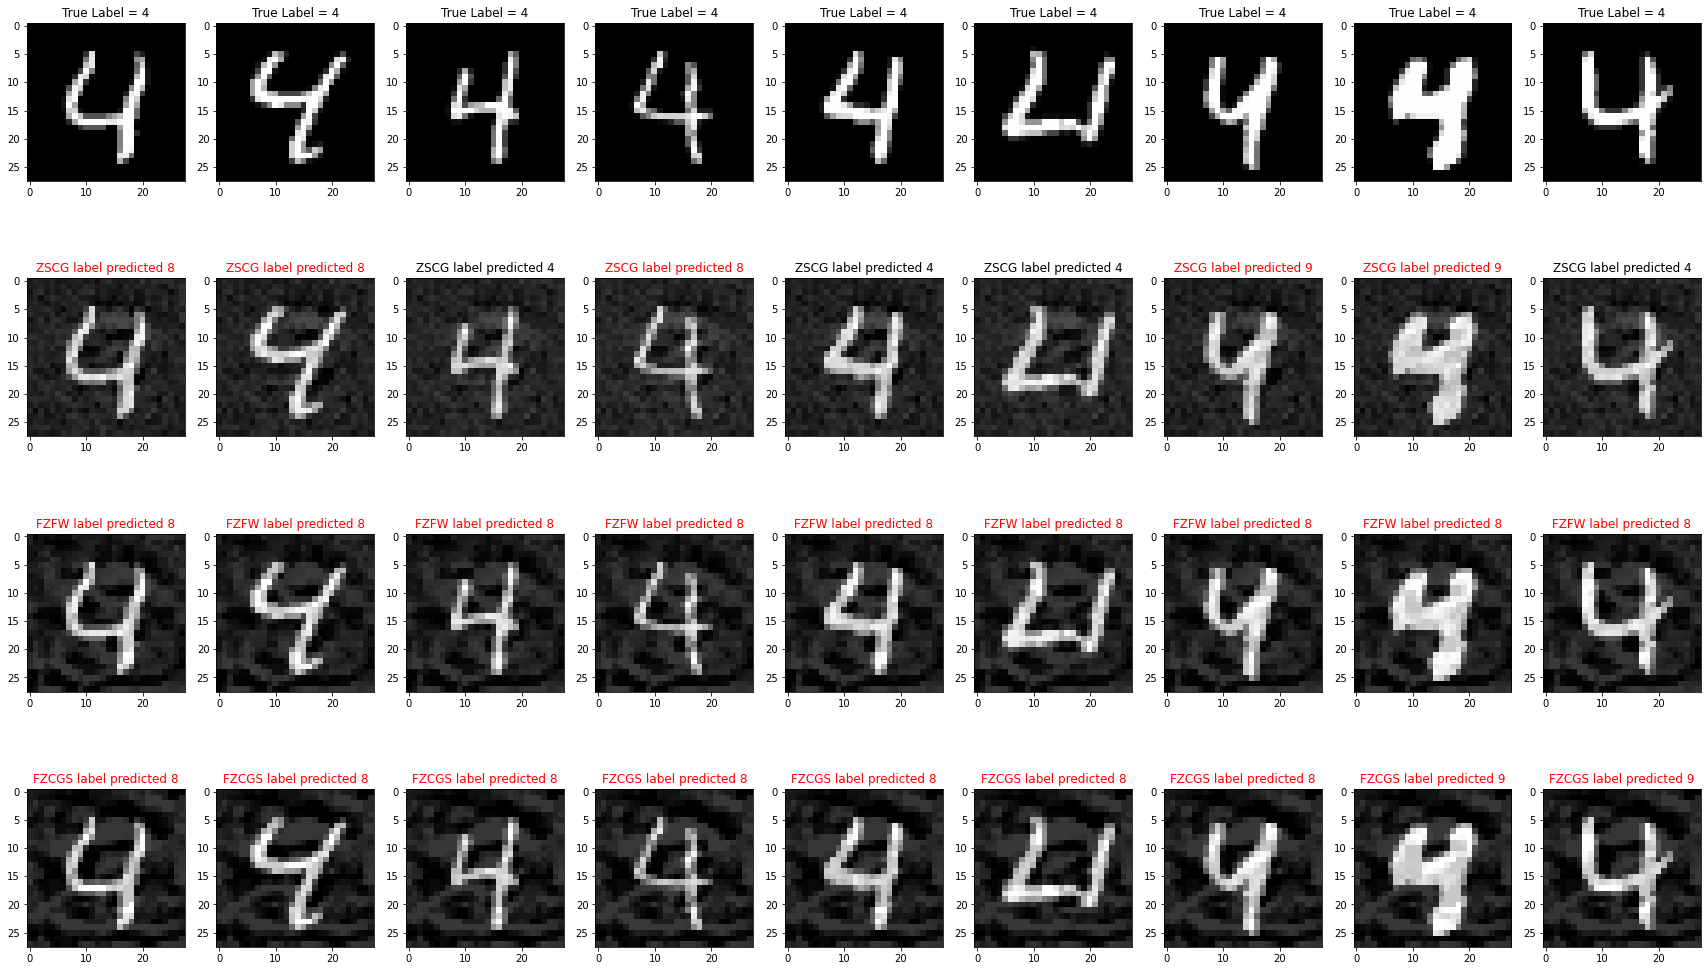

In [ ]:
final = {"ZSCG": x_Z, "FZFW": x_FZ, "FZCGS": x_FZC}
true_label = list(softmax(dnn.predict(x)).argmax(axis=1))
fig, ax = plt.subplots(4, n, figsize=(30,18))
for i in range(x.shape[0]):
  ax[0, i].imshow(x[i:i+1].reshape(28,28), cmap="gray")
  ax[0,i].set_title(f"True Label = {true_label[i]}")
row=0
for alg, data in final.items():
  row += 1
  predicted=softmax(dnn.predict(data)).argmax(axis=1)
  
  for j in range(n):
    color="black"
    ax[row, j].figure
    ax[row, j].imshow(data[j:j+1].reshape(28,28), cmap="gray", )
    if predicted[j] != true_label[j]:
      color="red"
    ax[row, j].set_title(f"{alg} label predicted {predicted[j]}", color=color)


plt.show()

#### Distorsion = 0.3

In [ ]:
n=9
x, _, y_true_in = get_data(n, 4)
epochs=100


In [ ]:
loss_Z, x_Z=ZSCG(epochs, 784, 0.3, 100, x, y_true_in, verbose=True)
loss_FZ, x_FZ=FZFW(epochs, 784,n, 0.3, x, y_true_in, verbose=True)
loss_FZC, x_FZC=FZCGS(epochs, 784,n, 0.3, x, y_true_in, verbose=True)


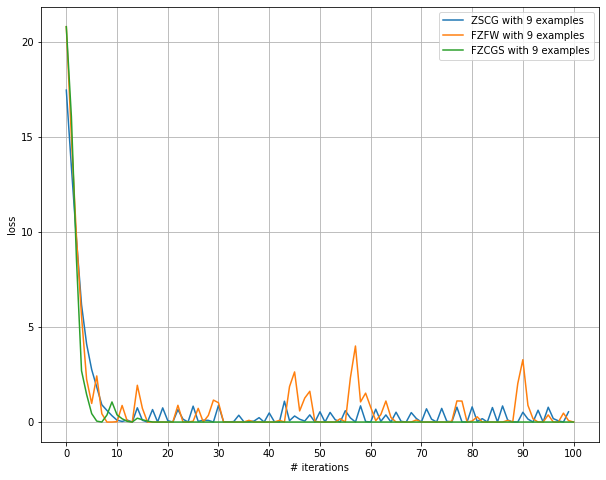

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs)

In [ ]:
from tabulate import tabulate
asr_alg1=attack_success_rate(x_Z, x)
asr_alg2=attack_success_rate(x_FZ, x)
asr_alg3=attack_success_rate(x_FZC, x)


print(tabulate([['ZSCG', asr_alg1], ['FZFW', asr_alg2], ['FZF-CGS', asr_alg3]], headers=['Algorithm', 'ASR (%)'], tablefmt='orgtbl'))

| Algorithm   |   ASR (%) |
|-------------+-----------|
| ZSCG        |      66.7 |
| FZFW        |     100   |
| FZF-CGS     |     100   |


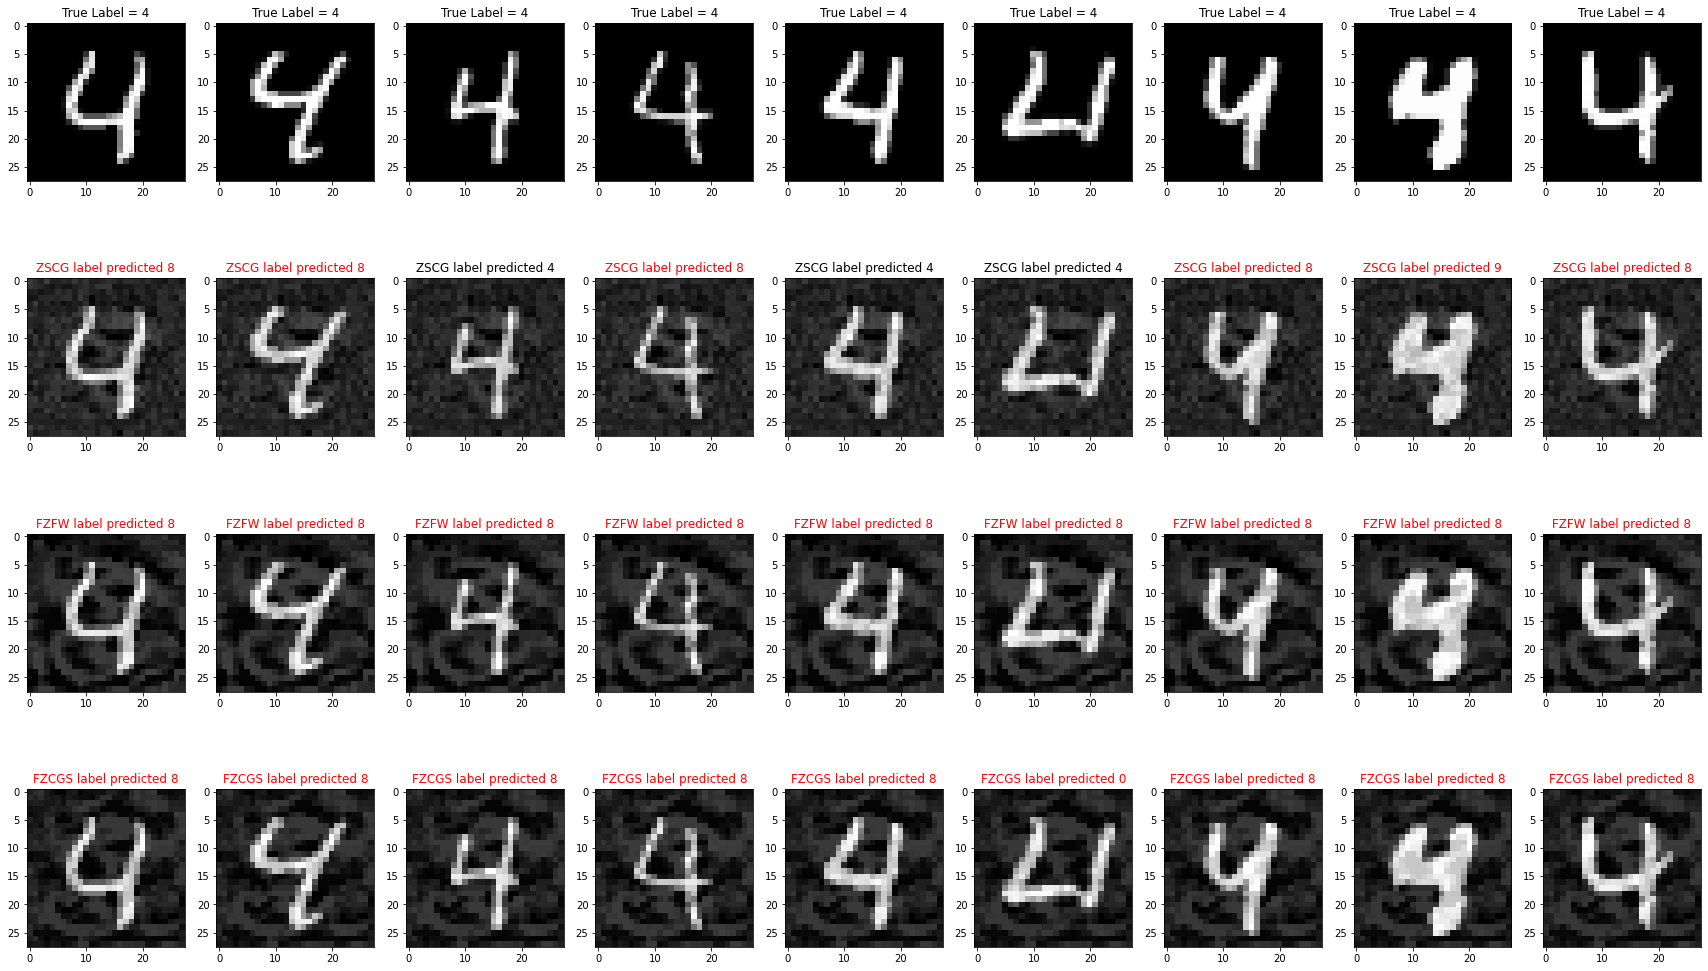

In [ ]:
final = {"ZSCG": x_Z, "FZFW": x_FZ, "FZCGS": x_FZC}
true_label = list(softmax(dnn.predict(x)).argmax(axis=1))
fig, ax = plt.subplots(4, n, figsize=(30,18))
for i in range(x.shape[0]):
  ax[0, i].imshow(x[i:i+1].reshape(28,28), cmap="gray")
  ax[0,i].set_title(f"True Label = {true_label[i]}")
row=0
for alg, data in final.items():
  row += 1
  predicted=softmax(dnn.predict(data)).argmax(axis=1)
  
  for j in range(n):
    color="black"
    ax[row, j].figure
    ax[row, j].imshow(data[j:j+1].reshape(28,28), cmap="gray", )
    if predicted[j] != true_label[j]:
      color="red"
    ax[row, j].set_title(f"{alg} label predicted {predicted[j]}", color=color)


plt.show()

## prove


In [ ]:
n=16
x, _, y_true_in = get_data(n, 4)
epochs=100
F(x, y_true_in)

21.861107007600367

In [ ]:
loss_Z_clip_30, x_Z1=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,-1,-1, verbose=False, clip=True)
loss_Z_clip_784, x_Z2=ZSCG(epochs, 784, 0.1, 784, x, y_true_in,-1,-1, verbose=False, clip=True)
loss_Z_no_clip_784, x_Z1=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,-1,-1, verbose=False, clip=False)
loss_Z_no_clip_30, x_Z1=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,-1,-1, verbose=False, clip=False)

loss_FZ_clip, x_FZ_clip=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=False,clip=True)
loss_FZC_clip, x_FZC_clip=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=False,clip=True)
loss_FZ_no_clip, x_FZ2_noclip=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=False,clip=False)
loss_FZC_no_clip, x_FZC3_noclip=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=False,clip=False)

(16, 784)
ZSCG Final loss =  15.840283036231995
(16, 784)
ZSCG Final loss =  11.081007286906242
(16, 784)
ZSCG Final loss =  8.683030411601067
(16, 784)
ZSCG Final loss =  8.766100659966469
FZFW Final loss =  9.906532481312752
FZCGS Final loss =  10.198811709880829
FZFW Final loss =  2.104233056306839
FZCGS Final loss =  0.7967582941055298


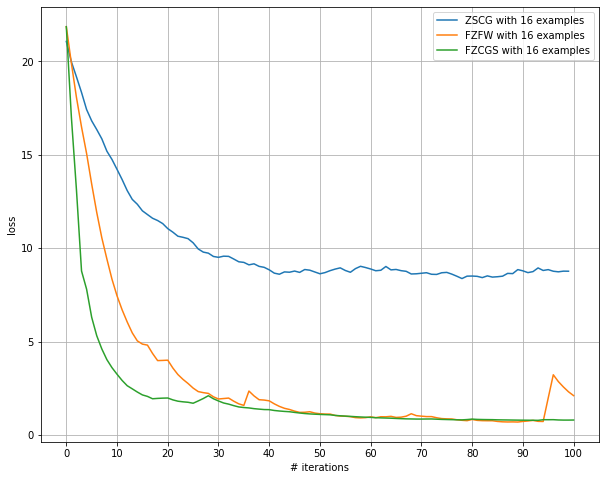

In [ ]:

plot_all(loss_Z_no_clip_30, loss_FZ_no_clip, loss_FZC_no_
         clip, epochs, n)


In [ ]:
loss_Z, x_Z=ZSCG(100, 784, 0.1, 30, x_test, y_test,-1,-1, verbose=True, clip=True)


(10000, 784)
Epoch: 0 Loss: 13.31427293956615 Distortion: 0.0


  9%|▊         | 866/10000 [00:59<10:28, 14.53it/s]


KeyboardInterrupt: ignored

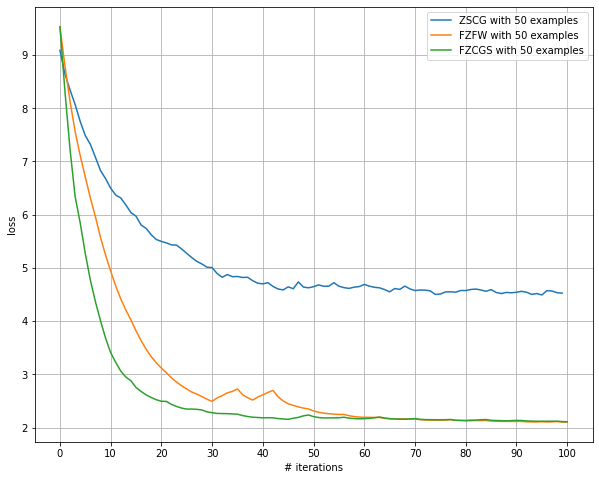

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)
# 50 examples; CLIP; mk=30

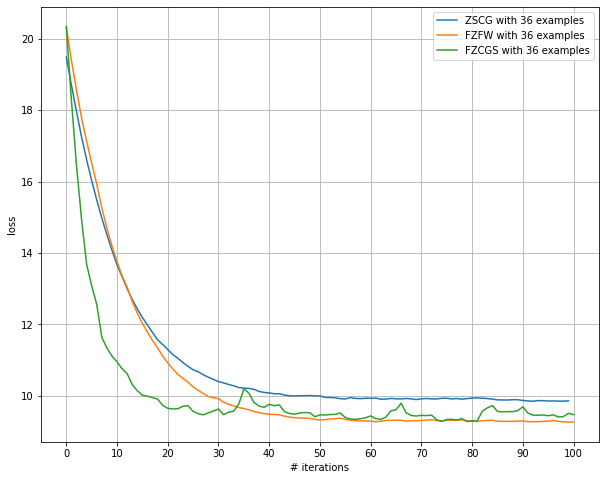

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)
# 36 examples; CLIP; MK=784; 

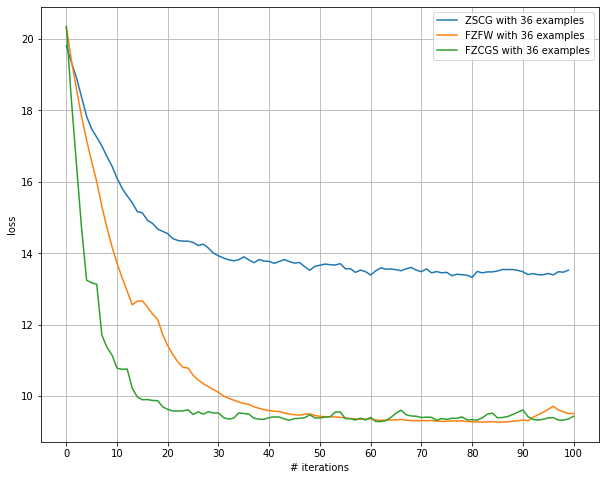

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC, epochs, n)
# 36 examples; CLIP; MK=30

In [ ]:

loss_Z2, x_Z2=ZSCG(epochs, 784, 0.1, 30, x, y_true_in,-1,-1, verbose=True, clip=False)
loss_FZ2, x_FZ2=FZFW(epochs, 784,n, 0.1,-1,-1 ,x, y_true_in, verbose=True, clip=False)
loss_FZC2, x_FZC2=FZCGS(epochs, 784,n, 0.1, -1,-1,-1,x, y_true_in, verbose=True, clip=False)

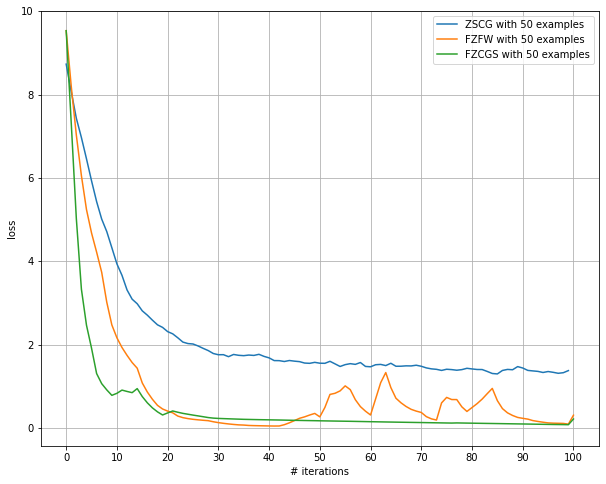

In [ ]:
plot_all(loss_Z2, loss_FZ2, loss_FZC2,epochs, n)
# 50 examples; NO CLIP; m_K = 30

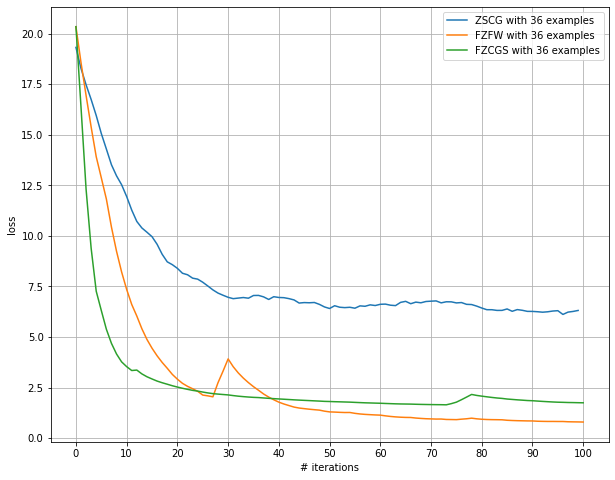

In [ ]:
plot_all(loss_Z2, loss_FZ2, loss_FZC2,epochs, n)
# 36 examples; NO CLIP; m_K = 30

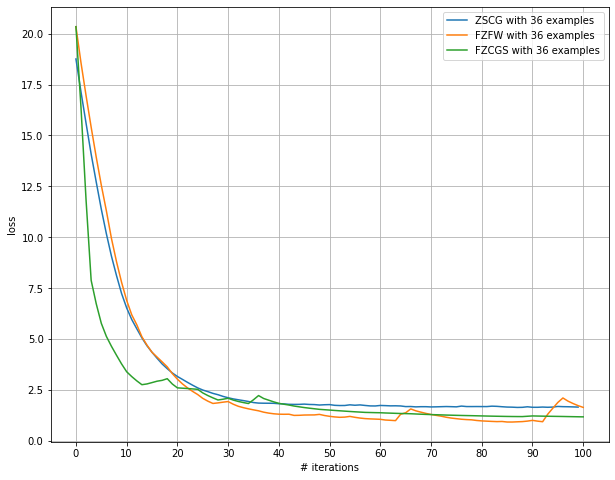

In [ ]:
plot_all(loss_Z2, loss_FZ2, loss_FZC2,epochs, n)
# 36 examples; NO CLIP; m_K = 784

In [ ]:
print(attack_success_rate(x_Z2, y_true_in))
print(attack_success_rate(x_Z, y_true_in))
print(attack_success_rate(x_FZ2, y_true_in))
print(attack_success_rate(x_FZ, y_true_in))
print(attack_success_rate(x_FZC2, y_true_in))
print(attack_success_rate(x_FZC, y_true_in))


56.0
24.0
86.0
46.0
86.0
50.0


In [ ]:
y_test.shape

(10000, 10)

In [ ]:
loss_Z, x_Z=ZSCG(50, 784, 0.1, 30, x_test, y_test,-1,-1, verbose=True, clip=False)
loss_FZ, x_FZ=FZFW(50, 784,x_test.shape[0], 0.1,-1,-1 ,x_test, y_test, verbose=True,clip=False)
loss_FZC, x_FZC=FZCGS(50, 784,x_test.shape[0], 0.1, -1,-1,-1,x_test, y_test, verbose=True,clip=False)

(10000, 784)
Epoch: 0 Loss: 13.31427293956615 Distortion: 0.0


  1%|          | 88/10000 [00:06<11:37, 14.20it/s]


KeyboardInterrupt: ignored

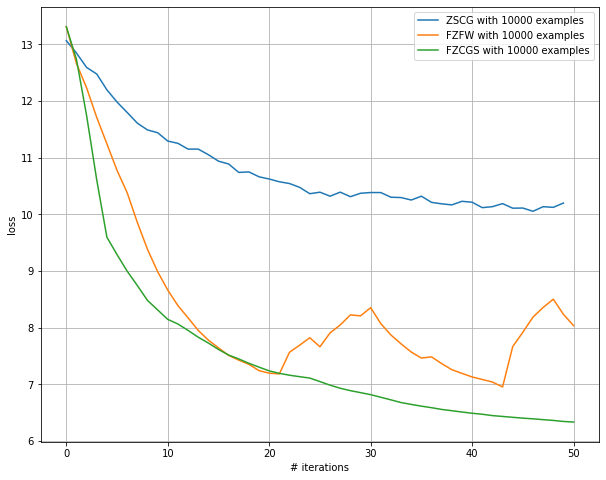

In [ ]:
plot_all(loss_Z, loss_FZ, loss_FZC,50, x_test.shape[0])
